In [1]:
import os 
import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
import seaborn as sns
from tqdm.notebook import tqdm

# import custom functions
os.chdir('..')
from FLOCK_GPS import DataLoading, Preprocessing, PACS, PacsFeats


Load data

In [2]:
# Initialize path to data (UTM-converted datasets)
data_dir = os.getcwd() + '\\SampleData'

# Load datasets
raw_datasets = DataLoading.load_data(data_dir)

# Re-shape datasets
datasets = DataLoading.pivot_datsets(raw_datasets)

Get the interpolated data

In [3]:
# get interpolated datasets
interp_datasets = Preprocessing.interpolate_datasets(datasets, threshold = 0.99)

Get movement periods


In [5]:
# get slices for movement periods and break times   
movements_bySquad, rests_bySquad, all_stops = Preprocessing.get_slices_byArea(interp_datasets, plot=False)

Extracting movement periods


100%|██████████| 5/5 [09:06<00:00, 109.29s/it]


Get the smoothed data of one example squad


In [ ]:
smooth_movements = Preprocessing.spline_smoothing(movements_bySquad[0], s=3e1, UTM=True)
# smooth_movements = Preprocessing.spline_smoothing(movements_bySquad[1], s=3e1, UTM=True)

Get a sample slice of data and apply the Path-Adapted Coordinate System (PACS) transformation

In [ ]:
# Orient ruck periods
ruck_slices_oriented = PACS.PACS_transform(smooth_movements)

re-orienting data


  0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 10/10 [11:32<00:00, 69.26s/it]


Get a names for feature extraction

In [26]:
names = smooth_movements[0].latitude.columns.tolist()

Spatial Exploration Index (SEI)

In [ ]:
SEIs = PacsFeats.get_SEIs(ruck_slices_oriented, names)
SEIs[0].mean()

100%|██████████| 10/10 [00:00<00:00, 86.71it/s]


Member 1    1.838214
Member 2    2.465762
Member 3    2.451295
Member 4    2.129212
Member 5    3.179814
Member 6    4.009413
dtype: float64

Nearest Neighbor (X and Y directions)

In [ ]:
x_neighbors, y_neighbors = PacsFeats.get_neighbor_dists(ruck_slices_oriented, names)
x_neighbors[0].mean()

Member 2    2.005735
Member 4    0.934236
Member 1    1.079955
Member 3    0.782469
Member 6    2.546885
Member 5    1.292377
dtype: float64

Get length/width ratio

In [ ]:
LW_ratios = PacsFeats.LW_ratio(ruck_slices_oriented)
LW_ratios[0]

0      0.826829
1      0.819132
2      0.830772
3      0.840067
4      0.720261
         ...   
992    0.926527
993    1.024339
994    1.144363
995    1.297708
996    1.555237
Length: 997, dtype: float64

Get distribution consistency

In [ ]:
X_ftest, Y_ftest = PacsFeats.dist_consistency_Ftest(ruck_slices_oriented, names)
X_wass_df, Y_wass_df = PacsFeats.dist_consistency_wasserstein(ruck_slices_oriented, names)

Plotting

In [27]:
# define colors for all plots 
color_dictionary = dict(zip(names, sns.color_palette(as_cmap=True)[:len(names)]))

Plot a sample plot of raw UTM cooradinates, PACS coordinates and a jointpot of PACS coordinates over time

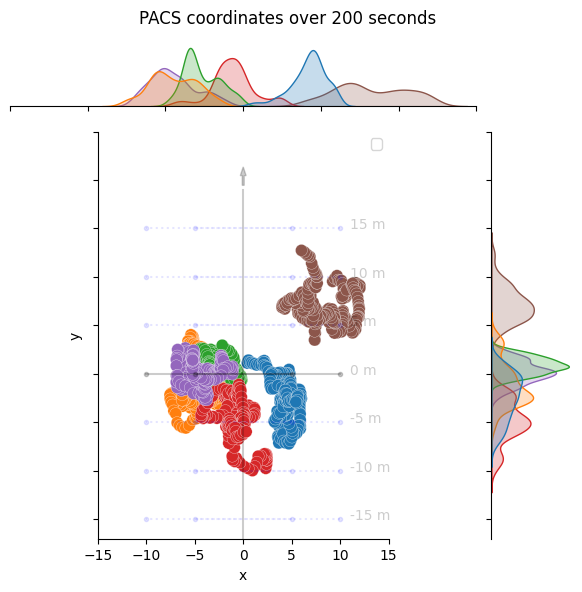

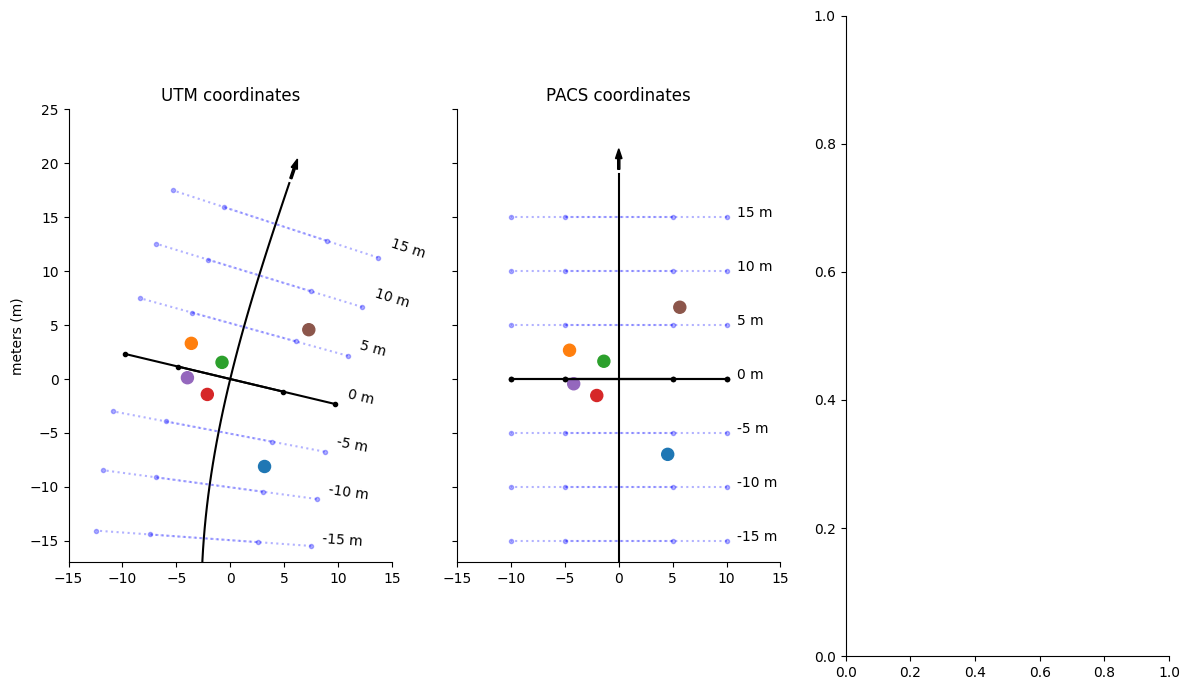

In [ ]:
# example time period if random=False, random time period if random=True
PACS.plot_sample_PACS_figure(smooth_movements, ruck_slices_oriented, random = False)

create a sample script that ony uses the centroid and centroid heading direction to compare existing methods

In [47]:
movements_bySquad[test_sq][1].iloc[1445]

            Member_ID
Unnamed: 0  Member 1          6241.0
            Member 2         16376.0
            Member 3         26576.0
            Member 4         36758.0
            Member 5         46957.0
            Member 6         57138.0
longitude   Member 1     -101.382146
            Member 2     -101.382118
            Member 3     -101.382122
            Member 4     -101.382098
            Member 5     -101.383029
            Member 6     -101.382096
latitude    Member 1       42.117713
            Member 2       42.117661
            Member 3       42.117677
            Member 4       42.117662
            Member 5       42.117827
            Member 6       42.117706
UTM_x       Member 1     3980.568835
            Member 2     3982.717099
            Member 3     3982.424162
            Member 4     3984.328989
            Member 5     3908.383987
            Member 6     3984.678419
UTM_y       Member 1     2669.880594
            Member 2     2664.096008
            Memb

In [9]:
smooth_movements = Preprocessing.spline_smoothing(movements_bySquad[test_sq], s=3e1, UTM=True)
# Get a sample slice of data and apply the Path-Adapted Coordinate System (PACS) transformation
# Orient ruck periods
ruck_slices_oriented = PACS.PACS_transform(smooth_movements)
# Get a names for feature extraction
names = smooth_movements[test_sq].latitude.columns.tolist()

re-orienting data


100%|██████████| 10/10 [11:35<00:00, 69.56s/it]


In [10]:

random_period = test_per
random_timepoint = test_time
sample_time_length = test_len

In [50]:

# get section
# random_slice = movements_bySquad[test_sq][random_period].iloc[random_timepoint:random_timepoint+sample_time_length].reset_index(drop=True)
random_slice = smooth_movements[random_period].iloc[random_timepoint:random_timepoint+sample_time_length].reset_index(drop=True)
random_slice_cent = pd.concat([random_slice.UTM_x.mean(axis=1), random_slice.UTM_y.mean(axis=1)], axis=1)

Xs = pd.concat([random_slice.UTM_x[name] - random_slice_cent[0] for name in random_slice.UTM_x.columns], axis=1, keys = ['UTM_x '+name for name in random_slice.UTM_x.columns])
Ys = pd.concat([random_slice.UTM_y[name] - random_slice_cent[1] for name in random_slice.UTM_y.columns], axis=1, keys = ['UTM_y '+name for name in random_slice.UTM_y.columns])

random_slice_norm = pd.concat([Xs, Ys], axis=1)

ger forward angle of centroid at each timepoint

In [51]:
forward_angles = pd.Series([math.degrees(math.atan2(row[1],row[0])) for _ , row in random_slice_cent.diff().iterrows()])

angle with respect to positive Y

In [52]:
forward_angles_y = 90- forward_angles

rotate locaitons around origin

In [53]:
def rotate(point, angle):
    """
    Rotate a point counterclockwise by a given angle around a given origin.

    The angle should be given in radians.
    """
    ox, oy = 0,0
    px, py = point

    qx = ox + math.cos(angle) * (px - ox) - math.sin(angle) * (py - oy)
    qy = oy + math.sin(angle) * (px - ox) + math.cos(angle) * (py - oy)
    return qx, qy

In [54]:
all_people_roated = []

names = random_slice.UTM_x.columns

color_dictionary = dict(zip(names, sns.color_palette(as_cmap=True)[:len(names)]))

for name in names:
    one_person = pd.concat([random_slice_norm[c] for c in random_slice_norm.columns if name in c], axis=1)

    # rotate
    new_pts = []
    for idx, row in one_person.iterrows():
        new_pts.append(rotate(row, math.radians(forward_angles_y.iloc[idx])))
    one_person_rotated = pd.DataFrame(new_pts, columns=['x', 'y'])

    one_person_rotated['ID'] = name

    all_people_roated.append(one_person_rotated)

df = pd.concat(all_people_roated)

hm_df = pd.concat([d.drop(columns='ID').rename(columns = {'x':name + ' longitude', 'y':name+' latitude'}) for d, name in zip(all_people_roated, names)], axis=1)

In [55]:
import numpy as np
import pandas as pd
from tqdm import tqdm
import math
import random
from scipy.interpolate import UnivariateSpline, splev, splprep
from scipy.optimize import minimize
from scipy.integrate import quad
import matplotlib.pyplot as plt
import seaborn as sns

from skimage.measure import shannon_entropy


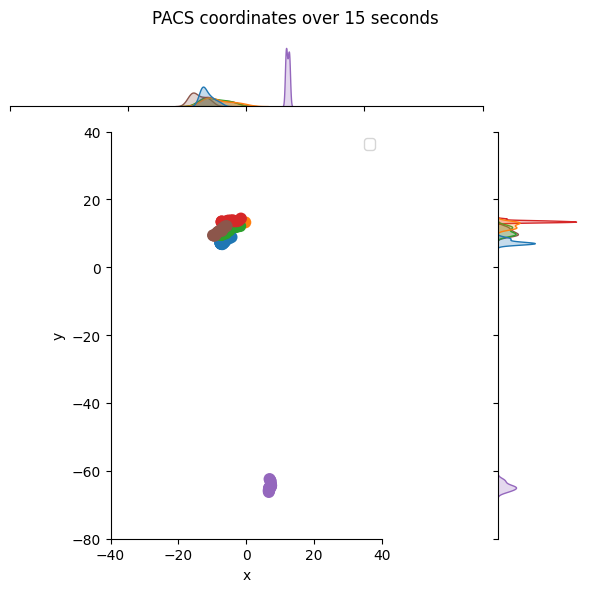

In [ ]:
time_length = test_len

# get group member names
names = smooth_movements[0].latitude.columns.tolist()

# define colors for all plots 
color_dictionary = dict(zip(names, sns.color_palette(as_cmap=True)[:len(names)]))


random_period = test_per
random_timepoint = test_time

# get section
random_slice = smooth_movements[random_period].iloc[random_timepoint:random_timepoint+time_length]
random_PACS_slice = ruck_slices_oriented[random_period].iloc[random_timepoint:random_timepoint+time_length]

#  get a sample path
x_UTM = random_slice[[('UTM_x', n)for n in names]].mean(axis=1)
y_UTM = random_slice[[('UTM_y', n) for n in names]].mean(axis=1)

# Get equivalent PACS coordinates
# make straight line to represent forward movement
x_PACS = pd.Series(0 * np.arange(time_length))
y_PACS = pd.Series(np.arange(time_length))

# initialize indiv datasets list
indivs_data = []

# loop through individuals
for name in names:
    this_person_data = random_PACS_slice[[c for c in random_PACS_slice.columns if name in c]]
    this_person_data.columns = 'x', 'y'
    this_person_data['ID']=name
    indivs_data.append(this_person_data)

# concat list of indiv datasets to single group dataset
data_to_plot = pd.concat(indivs_data)

# initialize jointfig
jointfig = sns.jointplot(data=data_to_plot.reset_index(), x='x', y='y', hue='ID', dropna=True, palette = color_dictionary, linewidth=0, joint_kws ={'s': 75})
jointfig.ax_joint.set_aspect('equal')

# jointfig params
# plt.suptitle('PACS coordinates over ' +str(time_length)+ ' seconds')
jointfig.ax_joint.legend([])
jointfig.ax_joint.set_ylim(ylim)
jointfig.ax_joint.set_xlim(xlim)
plt.tight_layout()

# # initialize random timepoint for UTM and PACS figs (should be middle of jointplots time-window)
# random_timepoint = random_timepoint + time_length//2
# sample_time_length = 40

# # get section
# random_slice = smooth_movements[random_period].iloc[random_timepoint:random_timepoint+sample_time_length]
# random_PACS_slice = ruck_slices_oriented[random_period].iloc[random_timepoint:random_timepoint+sample_time_length]

# #  get a sample path
# x_UTM = random_slice[[('UTM_x', n)for n in names]].mean(axis=1)
# y_UTM = random_slice[[('UTM_y', n) for n in names]].mean(axis=1)

# # Get equivalent PACS coordinates
# # make straight line to represent forward movement
# x_PACS = pd.Series(0 * np.arange(sample_time_length))
# y_PACS = pd.Series(np.arange(sample_time_length))

# # choose units (UTM or coords)
# pts = pd.concat([x_UTM, y_UTM], axis=1).to_numpy()

# # get distance values
# distance = np.cumsum( np.sqrt(np.sum( np.diff(pts, axis=0)**2, axis=1 )) )
# distance = np.insert(distance, 0, 0)#/distance[-1]

# # make a spline for each axis
# # splines = [UnivariateSpline(distance, coords, k=3, s=50) for coords in pts.T]

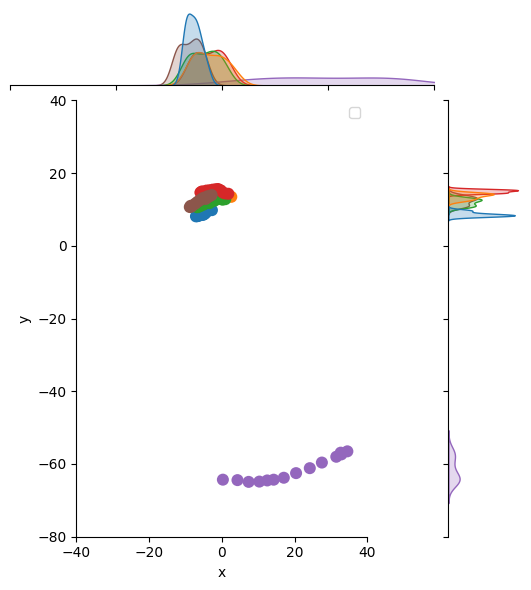

In [57]:
jointfig = sns.jointplot(data=df.reset_index(), x='x', y='y', hue='ID', dropna=True, palette = color_dictionary, linewidth=0, joint_kws ={'s': 75}, xlim=xlim, ylim=ylim)
jointfig.ax_joint.set_aspect('equal')
jointfig.ax_joint.legend([]) 

In [ ]:
# # entropy of these locations

# range = xlim, ylim

# PACS_ent = []
# reg_ent = []

# for name in names:

#     # name = 'Member 5'
#     this_person_PACS = random_PACS_slice[[c for c in random_PACS_slice.columns if name in c]]
#     this_person_reg = hm_df[[c for c in hm_df.columns if name in c]]
#     fig, ax = plt.subplots(2, figsize=(5,10))
#     PACShist = np.histogram2d(this_person_PACS[name +' longitude'], this_person_PACS[name +' latitude'], density=True, bins=100, range=range)[0]
#     sns.heatmap(PACShist, ax=ax[0])
#     reghist = np.histogram2d(this_person_reg[name +' longitude'], this_person_reg[name +' latitude'], density=True, bins=100, range=range)[0]
#     sns.heatmap(reghist, ax=ax[1])

#     plt.suptitle('reg '+ str(shannon_entropy(reghist)) +'   PACS: '+ str(shannon_entropy(PACShist)))

#     PACS_ent.append(shannon_entropy(PACShist))
#     reg_ent.append(shannon_entropy(reghist))

#     ax[0].set_aspect(1)
#     ax[1].set_aspect(1)




    

In [142]:
pd.DataFrame([PACS_ent, reg_ent]).T

0         1
0  0.024361  0.016800
1  0.018348  0.020802
2  0.016800  0.019982
3  0.015603  0.021367
4  0.010311  0.033468
5  0.014530  0.020021

In [175]:
sns.histplot(pd.DataFrame([PACS_ent, reg_ent], index=['PACS', 'Centroid']).T, kde=True)
sns.kdeplot(pd.DataFrame([PACS_ent, reg_ent], index=['PACS', 'Centroid']).T, x='')

ValueError: If using all scalar values, you must pass an index

In [6]:
test_time = 1445
test_per = 1
test_sq = 0
test_len = 15

# test_time = 1400
# test_per = 1
# test_sq = 0


test_time = 100
test_per = 2
test_sq = 2
test_len = 30


xlim = (-40, 40)
ylim = (-80,40)

In [7]:

from scipy.spatial import Voronoi, ConvexHull
from shapely.geometry import MultiPoint, Point, Polygon
from scipy.spatial import voronoi_plot_2d

from FLOCK import SpatialFeats


In [46]:
example_ruck = smooth_movements[test_per]
example_timepoint = example_ruck.iloc[test_time+95]

In [47]:
# get UTM points for this squad at this timepoint
points = [[example_timepoint['UTM_x',S], example_timepoint['UTM_y',S]] for S in example_timepoint['UTM_x'].index]

# normalize points
points = np.array(points) - np.mean(np.array(points), axis=0)

# Calculate Voronoi diagram
vor = Voronoi(points)

# get regions and vertices
regions, vertices = SpatialFeats.voronoi_finite_polygons_2d(vor)

# Create 'points' object
pts = MultiPoint([Point(i) for i in points])

# create convex hull mask
mask = pts.convex_hull

In [48]:
# define colors for all plots 
names = smooth_movements[0].latitude.columns.tolist()
color_dictionary = dict(zip(names, sns.color_palette(as_cmap=True)[:len(names)]))

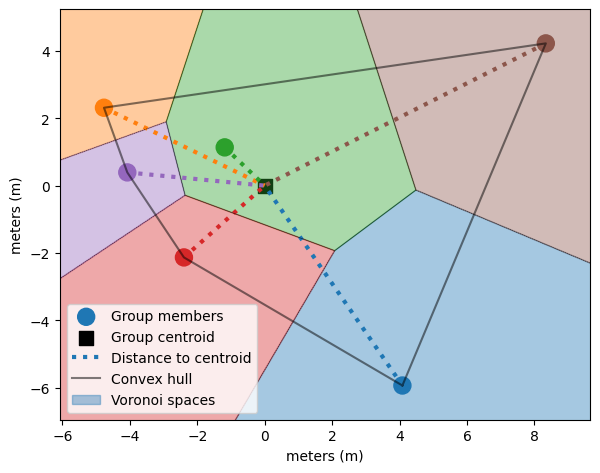

In [69]:
fig, axs = plt.subplots(1,1, figsize = (6.1,6.1))

# centorid distance



axs.scatter([p[0] for p in points], [p[1] for p in points], c = [color_dictionary[n] for n in names], s=150, label='Group members')
axs.scatter(0,0, label='Group centroid', marker='s', color='k', s=100)

# [plt.arrow(p[0] , p[1], -p[0]/3, -p[1]/3, width=0.1, length_includes_head=False, color='k') for p in points]
# [axs.plot((p[0],0) , (p[1],0), ls=':', lw=3, label='Distance to centroid') for p in points]
for cnt, p in enumerate(points):
    if cnt==0: axs.plot((p[0],0) , (p[1],0), ls=':', lw=3, label='Distance to centroid')
    else: axs.plot((p[0],0) , (p[1],0), ls=':', lw=3)


x,y = mask.exterior.xy
axs.plot(x,y, label='Convex hull', c='k', alpha=0.5)

axs.legend(loc='lower left')

axs.set_xlabel('meters (m)')
axs.set_ylabel('meters (m)')

# axs[0].set_title('Convex Hull (surface area)\nand\nDistance to the centroid (stretch index)')
# axs[0].tight_layout()
axs.set_aspect(1)

fig1 = voronoi_plot_2d(vor, ax=axs, point_size=0, show_vertices=False, c = [color_dictionary[n] for n in names], line_width = 0.3)

# axs.scatter([p[0] for p in points], [p[1] for p in points], c = [color_dictionary[n] for n in names], s=75)


x,y = mask.exterior.xy
# axs.plot(x,y, label='Convex hull', ls=':', c='k')#, alpha=0.5)

for r, n in zip(regions, names):
    x,y = Polygon(vertices[r]).exterior.xy
    if n==names[0]:
        axs.fill(x,y, c=color_dictionary[n], alpha=0.4, label='Voronoi spaces')
    else:
        axs.fill(x,y, c=color_dictionary[n], alpha=0.4)



axs.legend(loc='lower left')
plt.xlabel('meters (m)')
# axs[1].set_title('Voronoi spaces for each group member')
axs.set_aspect(1)

plt.tight_layout()
# plt.set_aspect(1)

# axs.set_ylim(axs.get_ylim())
# axs.set_ylim(axs.get_xlim())


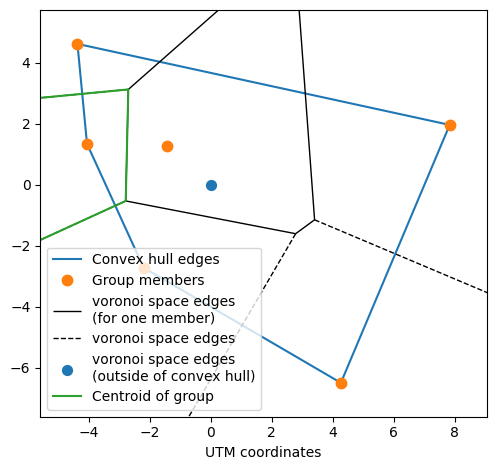

In [14]:

x,y = mask.exterior.xy
plt.plot(x,y)

fig = voronoi_plot_2d(vor, ax=plt.gca(), point_size=15, show_vertices=False, c = [color_dictionary[n] for n in names])

# fig = voronoi_plot_2d(vor, ax=plt.gca(), point_size=0, show_vertices=False, c = [color_dictionary[n] for n in names])

# plt.scatter([p[0] for p in points], [p[1] for p in points], c = [color_dictionary[n] for n in names], s=100)

# plt.gca().set_ylabel('UTM y')
plt.gca().set_xlabel('UTM coordinates')

plt.scatter(x=0, y=0, s=50)

x,y = Polygon(vertices[regions[4]]).exterior.xy
plt.plot(x,y, fillstyle='full')

plt.legend(['Convex hull edges', 'Group members', 'voronoi space edges\n(for one member)', 'voronoi space edges', 'voronoi space edges\n(outside of convex hull)', 'Centroid of group'], loc='lower left')

plt.tight_layout()
plt.gca().set_aspect(1)

Plot spatial metrics separately

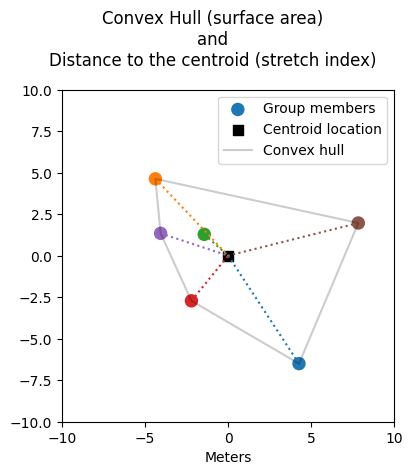

In [15]:
# centorid distance

plt.scatter([p[0] for p in points], [p[1] for p in points], c = [color_dictionary[n] for n in names], s=75, label='Group members')
plt.scatter(0,0, label='Centroid location', marker='s', color='k', s=50)

# [plt.arrow(p[0] , p[1], -p[0]/3, -p[1]/3, width=0.1, length_includes_head=False, color='k') for p in points]
[plt.plot((p[0],0) , (p[1],0), ls=':') for p in points]

x,y = mask.exterior.xy
plt.plot(x,y, label='Convex hull', c='k', alpha=0.2)

plt.legend()

plt.xlabel('Meters')

plt.suptitle('Convex Hull (surface area)\nand\nDistance to the centroid (stretch index)')
plt.tight_layout()
plt.gca().set_xlim(-10,10)
plt.gca().set_ylim(-10,10)
plt.gca().set_aspect(1)

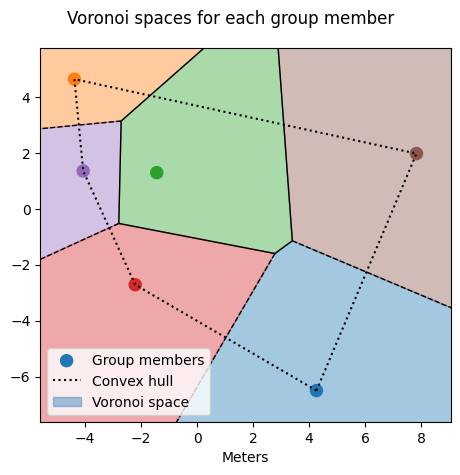

In [16]:

fig = voronoi_plot_2d(vor, ax=plt.gca(), point_size=0, show_vertices=False, c = [color_dictionary[n] for n in names])

plt.scatter([p[0] for p in points], [p[1] for p in points], c = [color_dictionary[n] for n in names], s=75, label='Group members')


x,y = mask.exterior.xy
plt.plot(x,y, label='Convex hull', ls=':', c='k')#, alpha=0.5)

for r, n in zip(regions, names):
    x,y = Polygon(vertices[r]).exterior.xy
    if n==names[0]:
        plt.fill(x,y, c=color_dictionary[n], alpha=0.4, label='Voronoi space')
    else:
        plt.fill(x,y, c=color_dictionary[n], alpha=0.4)



plt.legend(loc='lower left')

plt.xlabel('Meters')

plt.suptitle('Voronoi spaces for each group member')
plt.tight_layout()
plt.gca().set_aspect(1)

(-5.6040988412741175, 9.059805089500424)

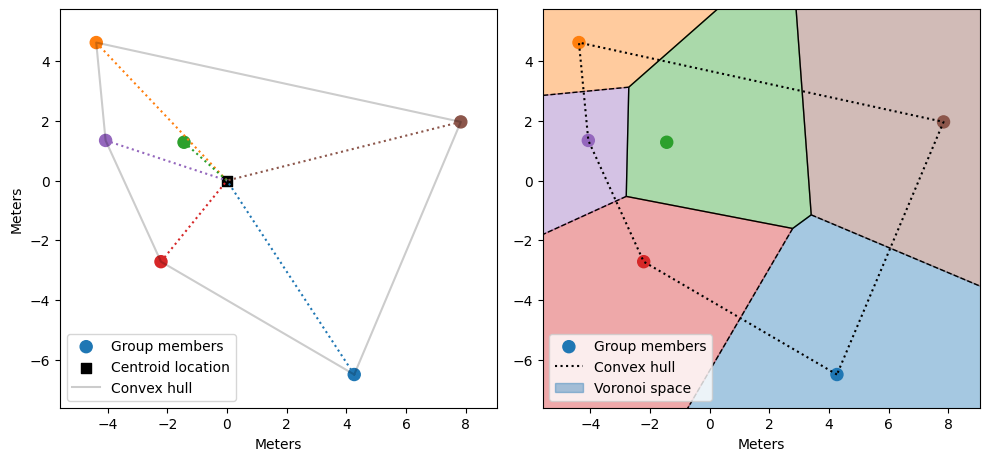

In [ ]:
fig, axs = plt.subplots(1,2, figsize=[10,20])

# centorid distance



axs[0].scatter([p[0] for p in points], [p[1] for p in points], c = [color_dictionary[n] for n in names], s=75, label='Group members')
axs[0].scatter(0,0, label='Centroid location', marker='s', color='k', s=50)

# [plt.arrow(p[0] , p[1], -p[0]/3, -p[1]/3, width=0.1, length_includes_head=False, color='k') for p in points]
[axs[0].plot((p[0],0) , (p[1],0), ls=':') for p in points]

x,y = mask.exterior.xy
axs[0].plot(x,y, label='Convex hull', c='k', alpha=0.2)

axs[0].legend(loc='lower left')

axs[0].set_xlabel('Meters')
axs[0].set_ylabel('Meters')

# axs[0].set_title('Convex Hull (surface area)\nand\nDistance to the centroid (stretch index)')
# axs[0].tight_layout()
axs[0].set_aspect(1)

fig1 = voronoi_plot_2d(vor, ax=axs[1], point_size=0, show_vertices=False, c = [color_dictionary[n] for n in names])

axs[1].scatter([p[0] for p in points], [p[1] for p in points], c = [color_dictionary[n] for n in names], s=75, label='Group members')


x,y = mask.exterior.xy
axs[1].plot(x,y, label='Convex hull', ls=':', c='k')#, alpha=0.5)

for r, n in zip(regions, names):
    x,y = Polygon(vertices[r]).exterior.xy
    if n==names[0]:
        axs[1].fill(x,y, c=color_dictionary[n], alpha=0.4, label='Voronoi space')
    else:
        axs[1].fill(x,y, c=color_dictionary[n], alpha=0.4)



axs[1].legend(loc='lower left')
plt.xlabel('Meters')
# axs[1].set_title('Voronoi spaces for each group member')
axs[1].set_aspect(1)

plt.tight_layout()
# plt.set_aspect(1)

axs[0].set_ylim(axs[1].get_ylim())
axs[0].set_xlim(axs[1].get_xlim())


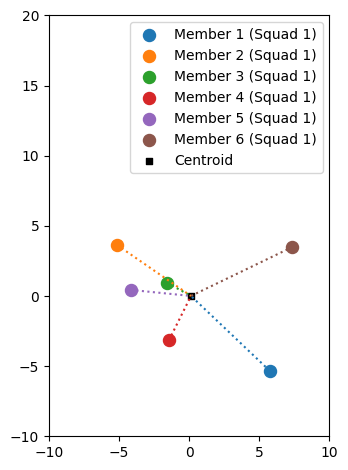

In [119]:
# for x in range(200):
data = ruck_slices_oriented[test_per].iloc[test_time+100]
for name in names: plt.scatter(data[name + ' longitude'], data[name + ' latitude'], color=color_dictionary[name], s=75, label=name)
plt.scatter(np.mean([data[name + ' longitude'] for name in names]), np.mean([data[name + ' latitude'] for name in names]), marker = 's', color='k', label='Centroid', s=20)
plt.gca().set_xlim(-10,10)
plt.gca().set_ylim(-10,20)
plt.gca().set_aspect(1)
plt.legend()
plt.tight_layout()


for name in names: plt.plot([data[name + ' longitude'], np.mean([data[x + ' longitude'] for x in names])], [data[name + ' latitude'], np.mean([data[x + ' latitude'] for x in names])], ls = ':')



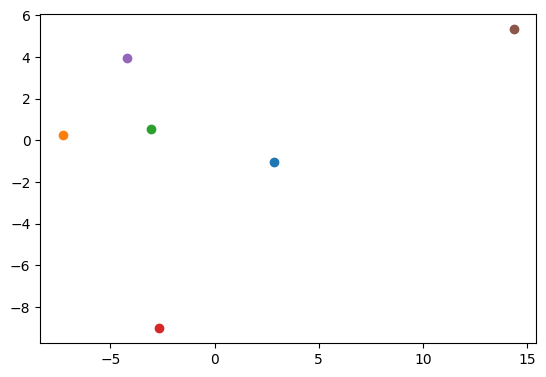

In [ ]:
for name in names: plt.scatter(data.UTM_x[name] - data.UTM_x.mean(), data.UTM_y[name] - data.UTM_y.mean(), color=color_dictionary[name])
plt.gca().set_aspect(1)

In [31]:
smooth_movements[1].UTM_x.drop(columns='Member 1')

Member_ID     Member 2     Member 3     Member 4     Member 5     Member 6
0          3749.167641  3763.423478  3763.248158  3761.320117  3749.155234
1          3749.205633  3763.006598  3762.990042  3761.116435  3748.573086
2          3748.837522  3762.413854  3762.380954  3760.925964  3748.044917
3          3748.051888  3761.845201  3761.662543  3760.696372  3747.576968
4          3747.505292  3761.377861  3760.994840  3760.479651  3747.167237
...                ...          ...          ...          ...          ...
1978       3793.067199  3793.629078  3794.668481  3820.739850  3793.820755
1979       3793.198641  3793.771891  3794.744376  3820.226379  3793.798884
1980       3793.464539  3794.001108  3794.749751  3819.717627  3793.847866
1981       3793.923816  3794.211016  3794.695006  3819.190945  3793.942624
1982       3794.409292  3794.864093  3794.571863  3818.431651  3794.150268

[1983 rows x 5 columns]

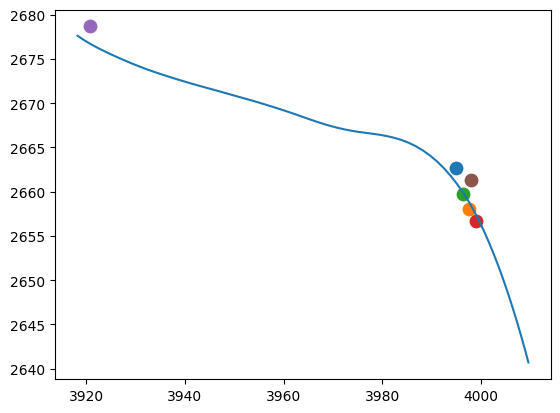

In [126]:

# plt.plot(movements_bySquad[0][1].UTM_x.mean(axis=1)[test_time:test_time+test_len], movements_bySquad[0][1].UTM_y.mean(axis=1)[test_time:test_time+test_len])
plt.plot(smooth_movements[1].UTM_x.drop(columns='Member 5').mean(axis=1)[test_time-50:test_time+test_len].rolling(10).mean(), smooth_movements[1].UTM_y.drop(columns='Member 5').mean(axis=1)[test_time-50:test_time+test_len].rolling(10).mean())
for n in smooth_movements[1].UTM_x.columns:
    plt.scatter(smooth_movements[1].UTM_x[n][test_time+10], smooth_movements[1].UTM_y[n][test_time+10], s=80)

In [132]:
smooth_movements[1]

Unnamed: 0                                                longitude  \
Member_ID   Member 1 Member 2 Member 3 Member 4 Member 5 Member 6    Member 1   
0             4796.0  14931.0  25131.0  35313.0  45512.0  55693.0 -101.385509   
1             4797.0  14932.0  25132.0  35314.0  45513.0  55694.0 -101.385510   
2             4798.0  14933.0  25133.0  35315.0  45514.0  55695.0 -101.385515   
3             4799.0  14934.0  25134.0  35316.0  45515.0  55696.0 -101.385522   
4             4800.0  14935.0  25135.0  35317.0  45516.0  55697.0 -101.385524   
...              ...      ...      ...      ...      ...      ...         ...   
1978          6774.0  16909.0  27109.0  37291.0  47490.0  57671.0 -101.384234   
1979          6775.0  16910.0  27110.0  37292.0  47491.0  57672.0 -101.384234   
1980          6776.0  16911.0  27111.0  37293.0  47492.0  57673.0 -101.384231   
1981          6777.0  16912.0  27112.0  37294.0  47493.0  57674.0 -101.384221   
1982          6778.0  16913.0  27113.0  37295.0  47494.0  57675.0 -101.384214   

                                               ...        UTM_y               \
Member_ID    Member 2    Member 3    Member 4  ...     Member 3     Member 4   
0         -101.385661 -101.385510 -101.385513  ...  4591.167295  4587.362182   
1         -101.385663 -101.385519 -101.385514  ...  4589.895345  4585.912852   
2         -101.385667 -101.385525 -101.385524  ...  4588.148390  4584.727502   
3         -101.385672 -101.385530 -101.385531  ...  4586.488593  4583.480402   
4         -101.385678 -101.385533 -101.385536  ...  4585.100793  4582.041347   
...               ...         ...         ...  ...          ...          ...   
1978      -101.384201 -101.384193 -101.384180  ...  2076.582172  2071.250739   
1979      -101.384198 -101.384191 -101.384177  ...  2074.810246  2069.778926   
1980      -101.384195 -101.384187 -101.384177  ...  2073.344838  2068.435131   
1981      -101.384190 -101.384186 -101.384176  ...  2072.401191  2067.221903   
1982      -101.384182 -101.384177 -101.384180  ...  2070.343997  2065.964657   

                                    Squad_ID                             \
Member_ID     Member 5     Member 6 Member 1 Member 2 Member 3 Member 4   
0          4575.935014  4527.611722  PLT1SQ1  PLT1SQ1  PLT1SQ1  PLT1SQ1   
1          4574.595247  4526.378874  PLT1SQ1  PLT1SQ1  PLT1SQ1  PLT1SQ1   
2          4573.407146  4525.028283  PLT1SQ1  PLT1SQ1  PLT1SQ1  PLT1SQ1   
3          4572.045836  4523.560740  PLT1SQ1  PLT1SQ1  PLT1SQ1  PLT1SQ1   
4          4570.822026  4522.006967  PLT1SQ1  PLT1SQ1  PLT1SQ1  PLT1SQ1   
...                ...          ...      ...      ...      ...      ...   
1978       2206.767305  2074.091628  PLT1SQ1  PLT1SQ1  PLT1SQ1  PLT1SQ1   
1979       2205.631403  2072.559705  PLT1SQ1  PLT1SQ1  PLT1SQ1  PLT1SQ1   
1980       2204.601721  2071.206896  PLT1SQ1  PLT1SQ1  PLT1SQ1  PLT1SQ1   
1981       2203.624710  2070.201244  PLT1SQ1  PLT1SQ1  PLT1SQ1  PLT1SQ1   
1982       2202.349539  2068.941915  PLT1SQ1  PLT1SQ1  PLT1SQ1  PLT1SQ1   

                             
Member_ID Member 5 Member 6  
0          PLT1SQ1  PLT1SQ1  
1          PLT1SQ1  PLT1SQ1  
2          PLT1SQ1  PLT1SQ1  
3          PLT1SQ1  PLT1SQ1  
4          PLT1SQ1  PLT1SQ1  
...            ...      ...  
1978       PLT1SQ1  PLT1SQ1  
1979       PLT1SQ1  PLT1SQ1  
1980       PLT1SQ1  PLT1SQ1  
1981       PLT1SQ1  PLT1SQ1  
1982       PLT1SQ1  PLT1SQ1  

[1983 rows x 36 columns]

4105
1983
1080
589


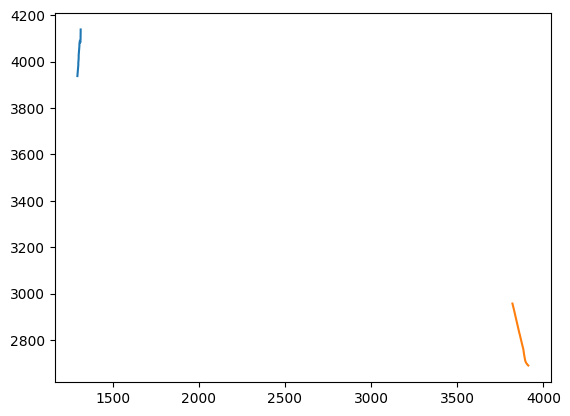

In [101]:
x = 1400
y = 1200
for s in smooth_movements:
    print(len(s.UTM_x.mean(axis=1)))
    plt.plot(s.UTM_x.mean(axis=1)[y:x], s.UTM_y.mean(axis=1)[y:x])
    # plt.plot(s.UTM_x.mean(axis=1), s.UTM_y.mean(axis=1))

In [207]:
data_to_plot

x          y        ID
1400  8.288503   9.289368  Member 1
1401  8.042210   9.650669  Member 1
1402  7.770433   9.732541  Member 1
1403  7.507904   9.557019  Member 1
1404  7.151627   9.600574  Member 1
...        ...        ...       ...
1595 -1.218368  10.346905  Member 6
1596 -1.205479  10.383348  Member 6
1597 -1.252454  10.090221  Member 6
1598 -1.427339  10.383885  Member 6
1599 -1.667113  10.865927  Member 6

[1200 rows x 3 columns]

In [233]:
import plotly.express as px

fig = px.scatter_3d(data_to_plot, x='x', y='y', z=data_to_plot.index, color='ID')

fig.update_layout(scene=dict(
                    xaxis_title='x',
                    yaxis_title='y',
                    zaxis_title='T'))

fig.update_layout(
    yaxis_scaleanchor="x",
    xaxis_scaleanchor="y",
)

fig.write_html(r'C:\Users\James\Downloads\first_figure.html', auto_open=True)

In [ ]:
s

Unnamed: 0.1                                        \
Member_ID Member 1 (Squad 1) Member 2 (Squad 1) Member 3 (Squad 1)   
0                    12019.0            25188.0            38388.0   
1                    12020.0            25189.0            38389.0   
2                    12021.0            25190.0            38390.0   
3                    12022.0            25191.0            38391.0   
4                    12023.0            25192.0            38392.0   
...                      ...                ...                ...   
1116                 13135.0            26304.0            39504.0   
1117                 13136.0            26305.0            39505.0   
1118                 13137.0            26306.0            39506.0   
1119                 13138.0            26307.0            39507.0   
1120                 13139.0            26308.0            39508.0   

                                                                    \
Member_ID Member 4 (Squad 1) Member 5 (Squad 1) Member 6 (Squad 1)   
0                    51586.0            64786.0            77977.0   
1                    51587.0            64787.0            77978.0   
2                    51588.0            64788.0            77979.0   
3                    51589.0            64789.0            77980.0   
4                    51590.0            64790.0            77981.0   
...                      ...                ...                ...   
1116                 52702.0            65902.0            79093.0   
1117                 52703.0            65903.0            79094.0   
1118                 52704.0            65904.0            79095.0   
1119                 52705.0            65905.0            79096.0   
1120                 52706.0            65906.0            79097.0   

                  Unnamed: 0                                        \
Member_ID Member 1 (Squad 1) Member 2 (Squad 1) Member 3 (Squad 1)   
0                    12019.0            25188.0            38388.0   
1                    12020.0            25189.0            38389.0   
2                    12021.0            25190.0            38390.0   
3                    12022.0            25191.0            38391.0   
4                    12023.0            25192.0            38392.0   
...                      ...                ...                ...   
1116                 13135.0            26304.0            39504.0   
1117                 13136.0            26305.0            39505.0   
1118                 13137.0            26306.0            39506.0   
1119                 13138.0            26307.0            39507.0   
1120                 13139.0            26308.0            39508.0   

                              ...              UTM_y                     \
Member_ID Member 4 (Squad 1)  ... Member 3 (Squad 1) Member 4 (Squad 1)   
0                    51586.0  ...         330.080559         330.813737   
1                    51587.0  ...         329.089379         329.815044   
2                    51588.0  ...         328.033566         328.706982   
3                    51589.0  ...         327.084369         327.709029   
4                    51590.0  ...         326.086683         326.567535   
...                      ...  ...                ...                ...   
1116                 52702.0  ...         741.281830         741.165149   
1117                 52703.0  ...         741.645555         741.622306   
1118                 52704.0  ...         741.886952         742.111891   
1119                 52705.0  ...         742.043529         742.558720   
1120                 52706.0  ...         742.029038         743.146124   

                                                          Squad_ID  \
Member_ID Member 5 (Squad 1) Member 6 (Squad 1) Member 1 (Squad 1)   
0                 331.177699         325.118567            Squad 1   
1                 330.213027         324.043356            Squad 1   
2                 329.20140

In [ ]:


def new_plot_sample_PACS_figure(smooth_movements, ruck_slices_oriented, random = True, time_length = 200):
    """
    Plot a sample image for the PACS transformation

    Args:
        smooth_movements (list of DataFrames): list of smoothed movement period dataframes (not oriented)
        ruck_slices_oriented (list of DataFrames): list of PACS oriented movement period dataframes
        random (bool, optional): If True, choose a random movement period and random timepoint, otherwise use specified example timepoint. Defaults to True.
        time_length (int, optional): length of time for the PACS to plot as a 2D histogram. Defaults to 200.

    Returns:
        None: None
    """

    # get group member names
    names = smooth_movements[0].latitude.columns.tolist()

    # define colors for all plots 
    color_dictionary = dict(zip(names, sns.color_palette(as_cmap=True)[:len(names)]))

    if random:
        # get random time periods
        random_period = np.random.randint(len(ruck_slices_oriented))
        random_timepoint = np.random.randint(len(ruck_slices_oriented[random_period])-time_length)
    else:
        random_period = test_per
        random_timepoint = test_time
    
    # get section
    random_slice = smooth_movements[random_period].iloc[random_timepoint:random_timepoint+time_length]
    random_PACS_slice = ruck_slices_oriented[random_period].iloc[random_timepoint:random_timepoint+time_length]

    #  get a sample path
    x_UTM = random_slice[[('UTM_x', n)for n in names]].mean(axis=1)
    y_UTM = random_slice[[('UTM_y', n) for n in names]].mean(axis=1)

    # Get equivalent PACS coordinates
    # make straight line to represent forward movement
    x_PACS = pd.Series(0 * np.arange(time_length))
    y_PACS = pd.Series(np.arange(time_length))

    # initialize indiv datasets list
    indivs_data = []

    # loop through individuals
    for name in names:
        this_person_data = random_PACS_slice[[c for c in random_PACS_slice.columns if name in c]]
        this_person_data.columns = 'x', 'y'
        this_person_data['ID']=name
        indivs_data.append(this_person_data)

    # concat list of indiv datasets to single group dataset
    data_to_plot = pd.concat(indivs_data)

    # initialize jointfig
    jointfig = sns.jointplot(data=data_to_plot.reset_index(), x='x', y='y', hue='ID', dropna=True, palette = color_dictionary, linewidth=.2, joint_kws ={'s': 75})
    jointfig.ax_joint.set_aspect('equal')

    # jointfig params
    plt.suptitle('PACS coordinates over ' +str(time_length)+ ' seconds')
    # jointfig.ax_joint.legend([])
    jointfig.ax_joint.set_ylim([-15,25])
    jointfig.ax_joint.set_xlim([-15,15])
    plt.tight_layout()

    # initialize random timepoint for UTM and PACS figs (should be middle of jointplots time-window)
    random_timepoint = random_timepoint + time_length//2
    sample_time_length = 40

    # get section
    random_slice = smooth_movements[random_period].iloc[random_timepoint:random_timepoint+sample_time_length]
    random_PACS_slice = ruck_slices_oriented[random_period].iloc[random_timepoint:random_timepoint+sample_time_length]

    #  get a sample path
    x_UTM = random_slice[[('UTM_x', n)for n in names]].mean(axis=1)
    y_UTM = random_slice[[('UTM_y', n) for n in names]].mean(axis=1)

    # Get equivalent PACS coordinates
    # make straight line to represent forward movement
    x_PACS = pd.Series(0 * np.arange(sample_time_length))
    y_PACS = pd.Series(np.arange(sample_time_length))

    # choose units (UTM or coords)
    pts = pd.concat([x_UTM, y_UTM], axis=1).to_numpy()

    # get distance values
    distance = np.cumsum( np.sqrt(np.sum( np.diff(pts, axis=0)**2, axis=1 )) )
    distance = np.insert(distance, 0, 0)#/distance[-1]

    # make a spline for each axis
    splines = [UnivariateSpline(distance, coords, k=3, s=50) for coords in pts.T]

    # get evenly spaced points ~1 unit along spline
    spaced_distance = np.arange(len(distance))
    points_spaced = np.vstack( spl(spaced_distance) for spl in splines ).T

    x_UTM = pd.Series(points_spaced[:,0])
    y_UTM = pd.Series(points_spaced[:,1])

    # set tick params
    # set which tick to make as t=0
    # make a ratio of total time period
    ztick = sample_time_length//2

    # tick distance from line and how many ticks
    dist_from_line = 10
    n_ticks = 2

    # make paths with respect to zero (t=0)
    x_UTM = x_UTM - x_UTM.iloc[int(ztick)]
    y_UTM = y_UTM - y_UTM.iloc[int(ztick)]
    x_PACS = x_PACS - x_PACS.iloc[int(ztick)]
    y_PACS = y_PACS - y_PACS.iloc[int(ztick)]

    # make plots
    fig, axs = plt.subplots(1, 3)

    axs[2] = jointfig.ax_joint

    # loop through two plots. UTM and PACS
    for x, y, ax, plottype in zip([x_UTM, x_PACS, x_PACS], [y_UTM, y_PACS, y_PACS], axs, ['UTM', 'PACS', 'joint']):

        # set up curve
        curve_df = pd.DataFrame()
        curve_df['x'] = x
        curve_df['y'] = y

        # get normalized slope for y axis ticks
        curve_diff = curve_df.diff()
        curve_slope = curve_diff['y'] / curve_diff['x']
        norm_slope = -1/curve_slope

        # plot the path
        if plottype == 'joint':
            ax.plot(x, y, color='k', label='Path', alpha=0.2)
            ar = ax.arrow(x.iloc[-1], y.iloc[-1],dx=x.diff().iloc[-1], dy=y.diff().iloc[-1], color='k', width=0.2, head_starts_at_zero = 1, alpha=0.2)
        else:
            ax.plot(x, y, color='k', label='Path')
            ar = ax.arrow(x.iloc[-1], y.iloc[-1],dx=x.diff().iloc[-1], dy=y.diff().iloc[-1], color='k', width=0.2, head_starts_at_zero = 1)

        # initialize x and y vals for ticks
        X_vals = []
        Y_vals = []

        # plot every X ticks
        evtick = 5

        # plot ticks
        for count, (this_x, this_y, this_slope) in enumerate(zip(x[::evtick], y[::evtick], norm_slope[::evtick])):
            
            # if slop is na skip
            if math.isnan(this_slope): continue

            # assign m as slope
            m = this_slope

            # loop through steps in path to plot ricks
            for l in np.arange(0, dist_from_line/n_ticks + dist_from_line, dist_from_line/n_ticks)[1:]:

                # ticks here
                dx = (l / math.sqrt(1 + (m * m)))
                dy = m * dx
                Px = this_x + dx
                Py = this_y + dy
                Nx = this_x - dx
                Ny = this_y - dy

                # append ticks
                X_vals = [Px, Nx]
                Y_vals = [Py, Ny]

                # make t=0 a darker tick, adjust alpha for PACS joint plot
                if count == (ztick//evtick):
                    if plottype == 'PACS':
                        ax.plot(X_vals, Y_vals, color='k', marker = '.', markevery=1, label = 't = 0')
                    if plottype == 'joint':
                        ax.plot(X_vals, Y_vals, color='k', marker = '.', markevery=1, alpha = 0.2)
                    else:
                        ax.plot(X_vals, Y_vals, color='k', marker = '.', markevery=1)
                else:
                    if plottype == 'joint':
                        ax.plot(X_vals, Y_vals, ls=':', color='b', marker = '.', markevery=1, alpha = 0.1)
                    else:
                        ax.plot(X_vals, Y_vals, ls=':', color='b', marker = '.', markevery=1, alpha = 0.3)
                
                if not l == dist_from_line/n_ticks:
                    if plottype == 'joint': alpha=0.2
                    else: alpha=1
                    ax.text(X_vals[0] + 1 , Y_vals[0], f'{(count-4)*evtick} m', rotation = math.degrees(math.tanh(m)), alpha=alpha)

                # set some plotting parameters to make all axes equal
                ax.set_ylim([-17,25])
                ax.set_xlim([-15,15])
                ax.set_aspect('equal')#, adjustable="datalim")
                if plottype =='UTM': ax.set_ylabel('meters (m)')
                else: ax.set_yticklabels([])

    # set size for scatterplots and jopint plots
    dot_size = 75

    # plot individuals on path at that time 0
    axs[0].scatter(random_slice.iloc[int(ztick)][[('UTM_x', n)for n in names]] - random_slice.iloc[int(ztick)][[('UTM_x', n)for n in names]].mean(), random_slice.iloc[int(ztick)][[('UTM_y', n)for n in names]] - random_slice.iloc[int(ztick)][[('UTM_y', n)for n in names]].mean(), c = [color_dictionary[n] for n in names], s=dot_size)
    axs[1].scatter(random_PACS_slice.iloc[int(ztick)][[n+' longitude' for n in names]], random_PACS_slice.iloc[int(ztick)][[n+' latitude' for n in names]], c = [color_dictionary[n] for n in names], s=dot_size)

    # plot params
    axs[0].set_title('UTM coordinates')
    axs[1].set_title('PACS coordinates')
    fig.set_size_inches(12, 7)
    plt.tight_layout()
    sns.despine()
    plt.show()

    return None



NameError: name 'UnivariateSpline' is not defined

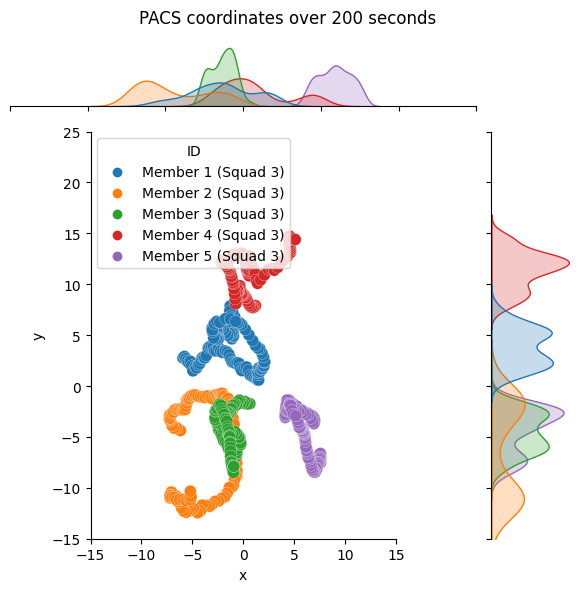

In [ ]:

new_plot_sample_PACS_figure(smooth_movements, ruck_slices_oriented, random = False, time_length = 200)

In [180]:
from tqdm import tqdm

re-orienting data


re-orienting data


  0%|          | 0/3 [00:00<?, ?it/s]




































































































































































































































































































































































































































































































































































































































































































































































































































































































































































































re-orienting data


  0%|          | 0/10 [00:00<?, ?it/s]



































































































































































































































































































































































































































































































































































































































































































































































































































































































































































































re-orienting data


  0%|          | 0/7 [00:00<?, ?it/s]




































































































































































































































































































































































































































































































































































































































































































































































































































































































































































































re-orienting data


  0%|          | 0/6 [00:00<?, ?it/s]




































































































































































































































































































































































































































































































































































































































































































































































































































































































































































































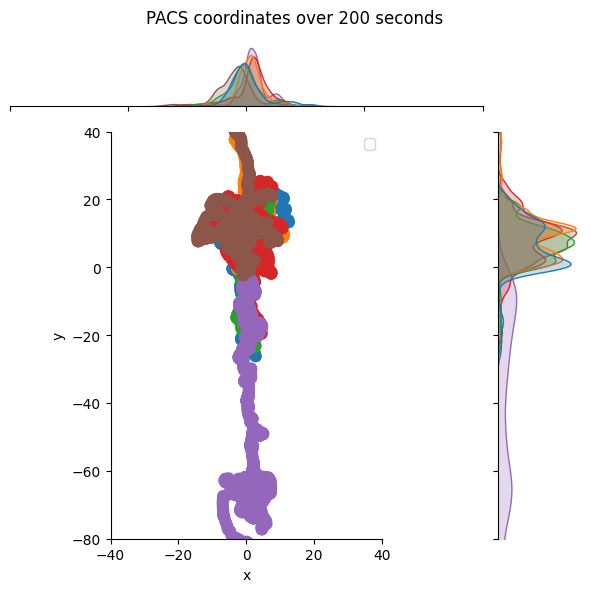

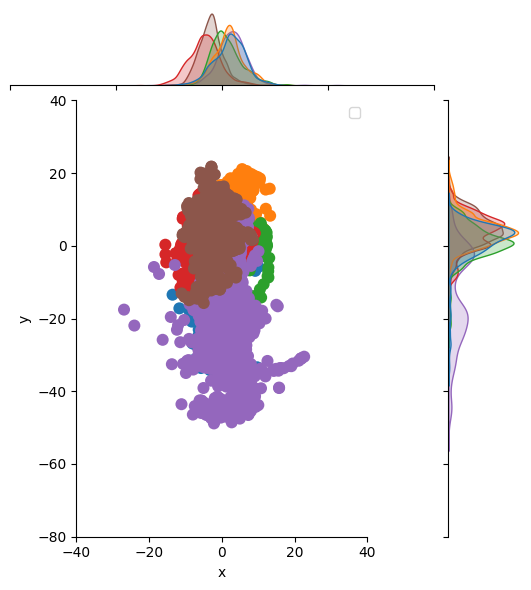

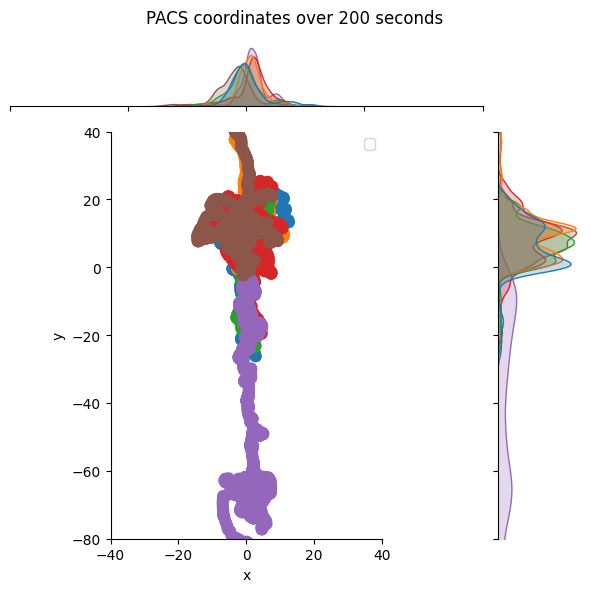

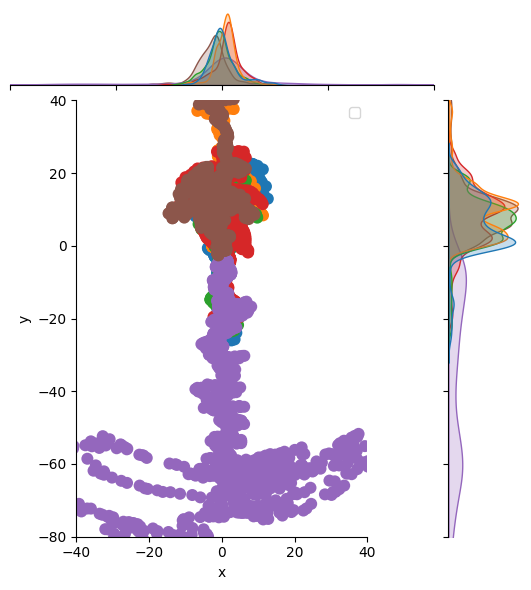

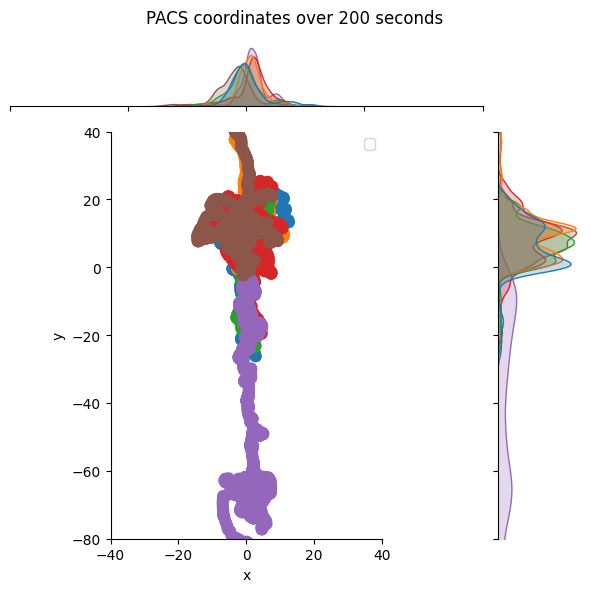

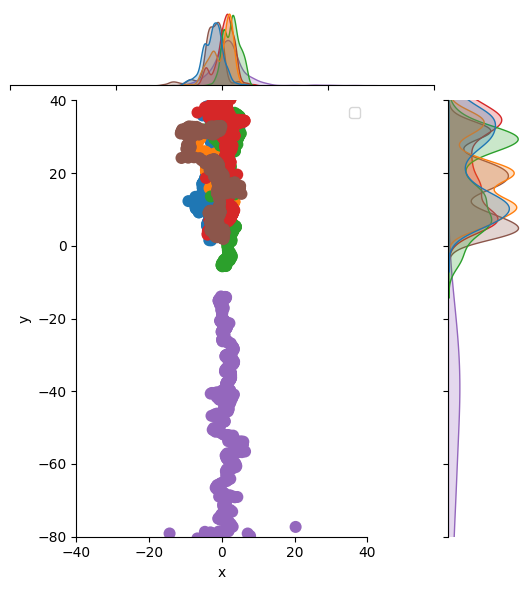

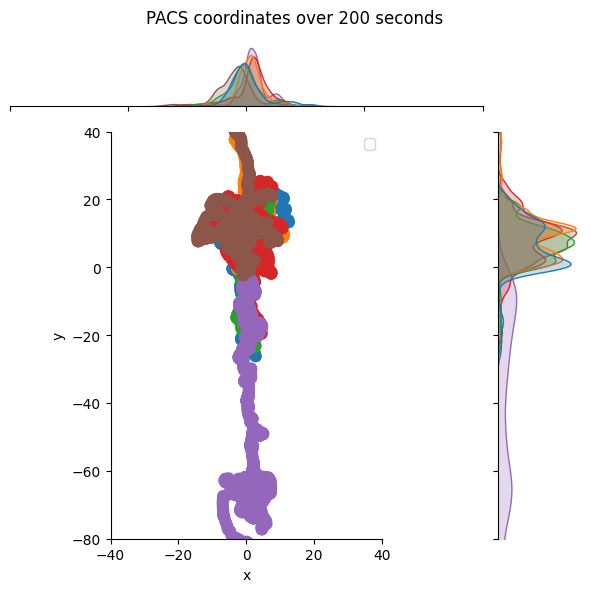

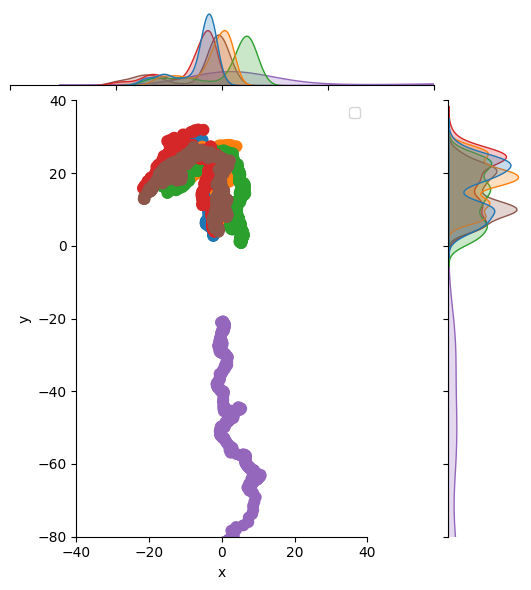

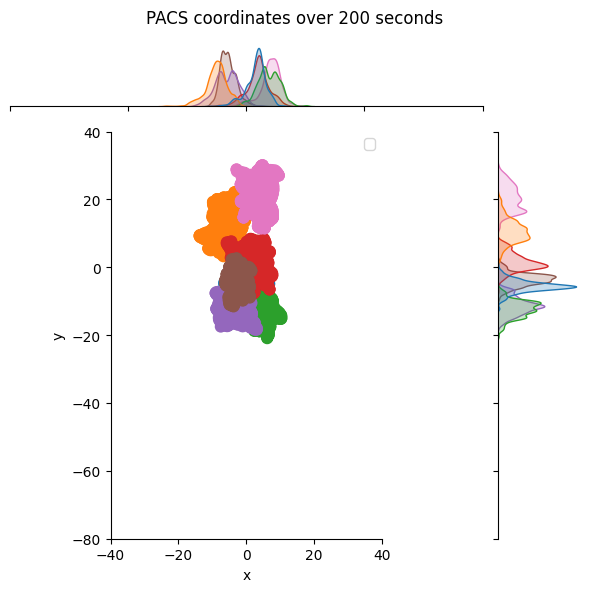

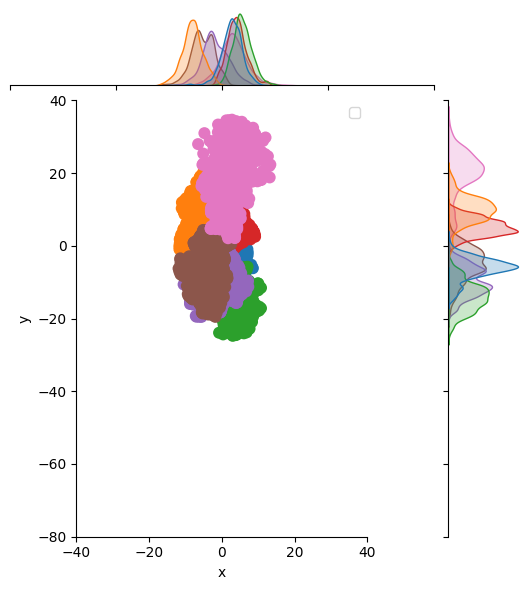

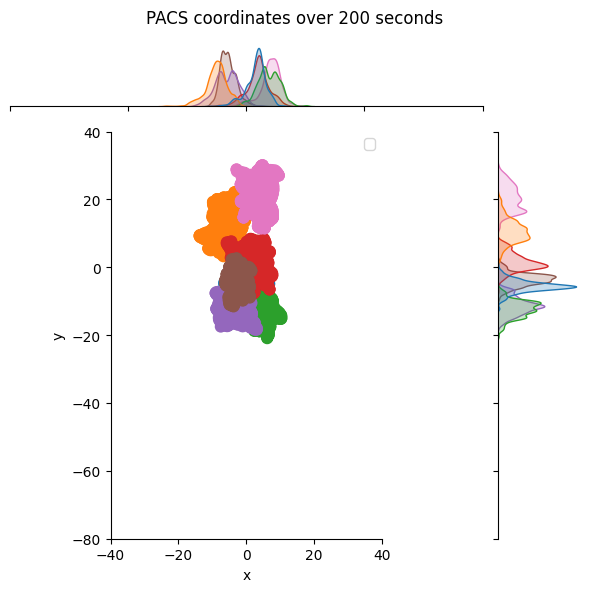

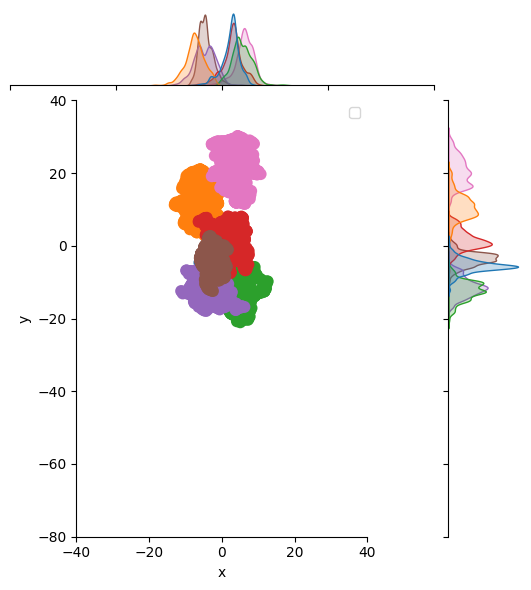

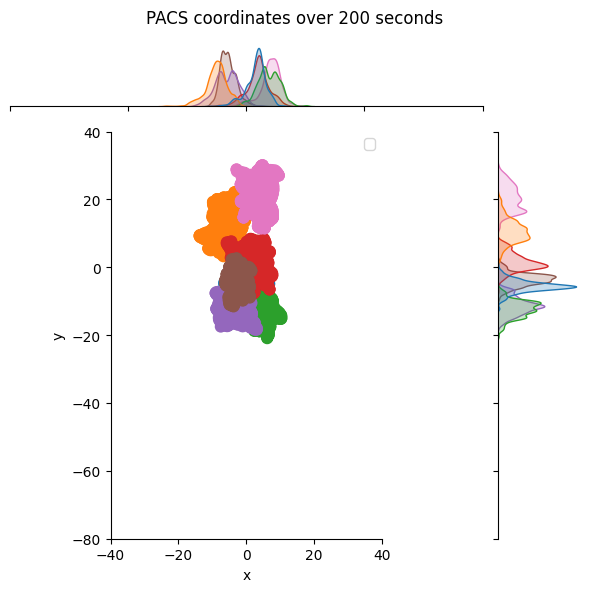

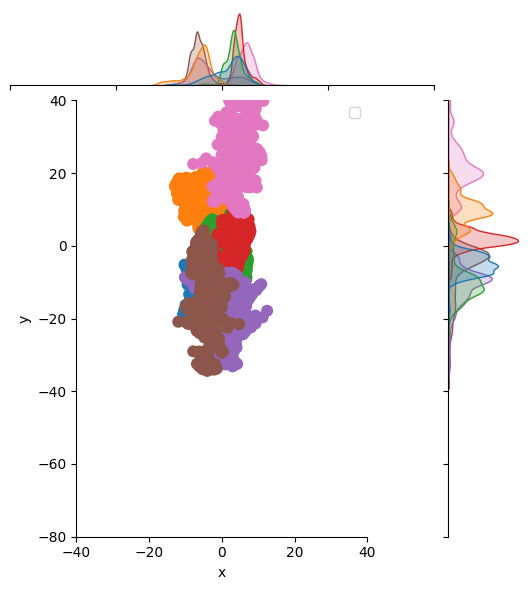

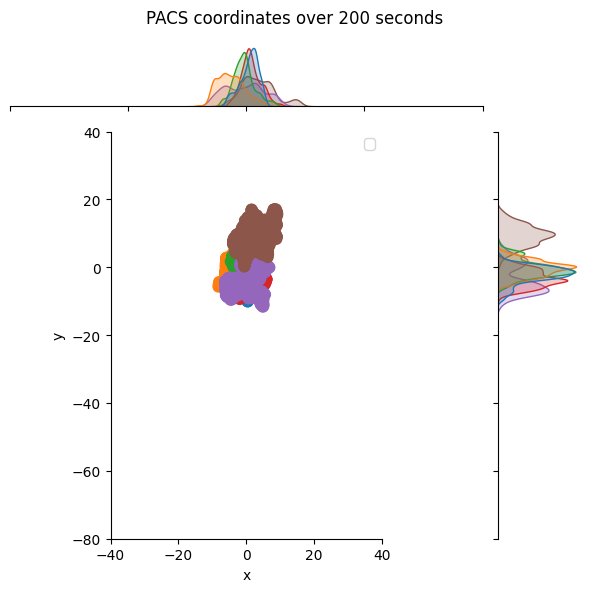

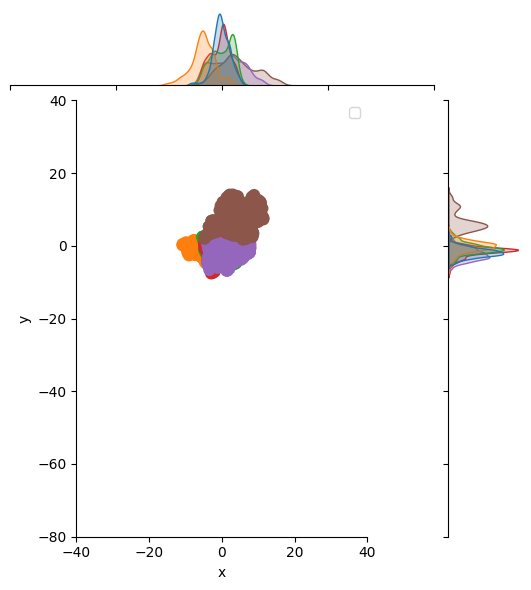

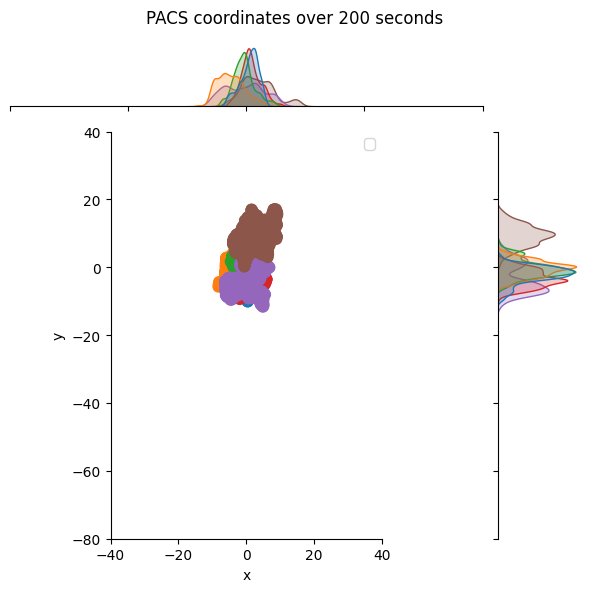

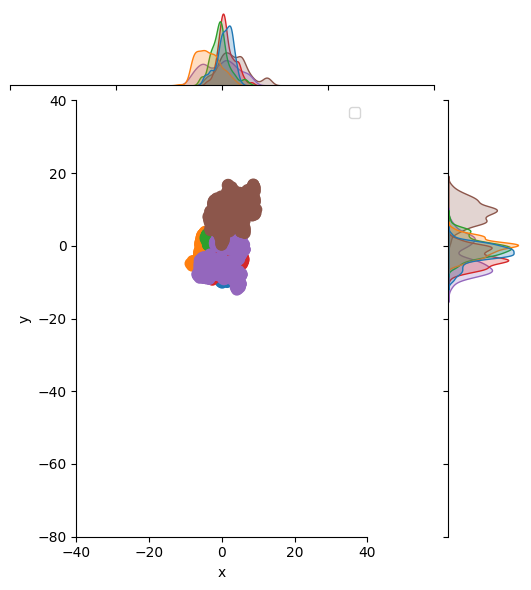

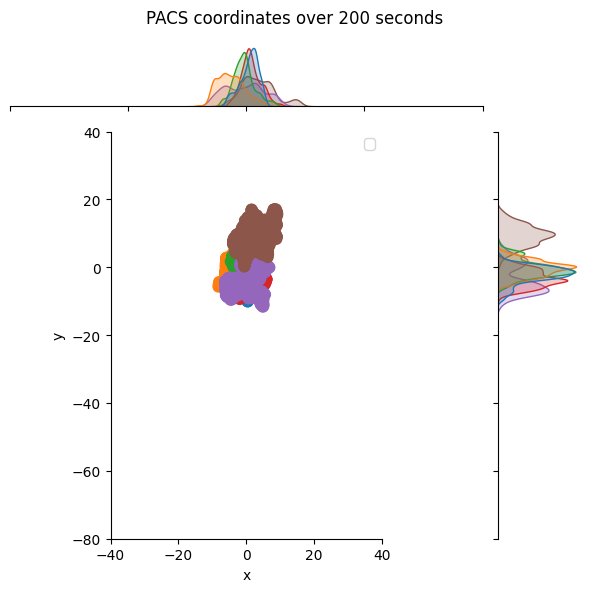

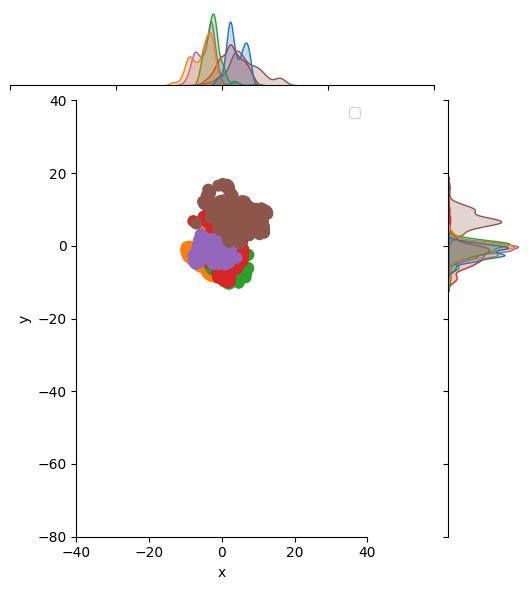

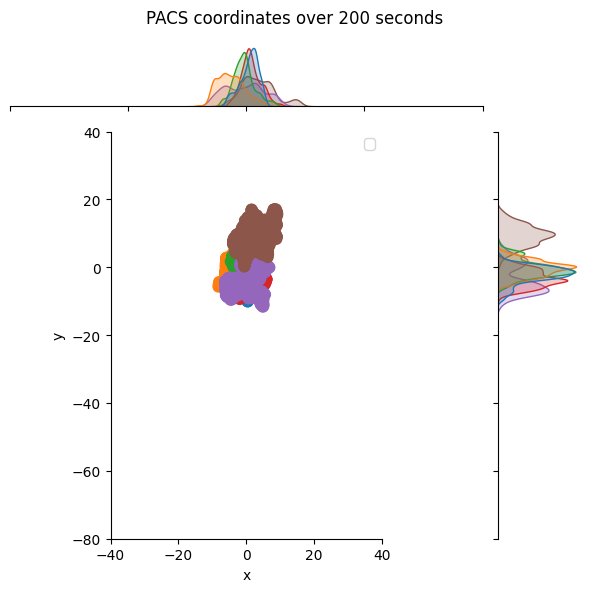

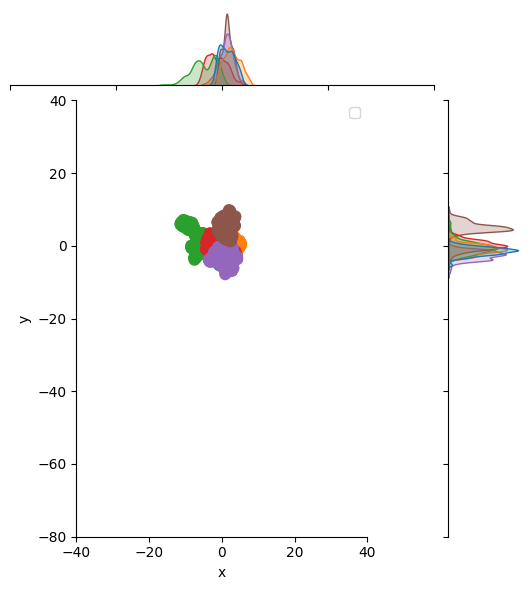

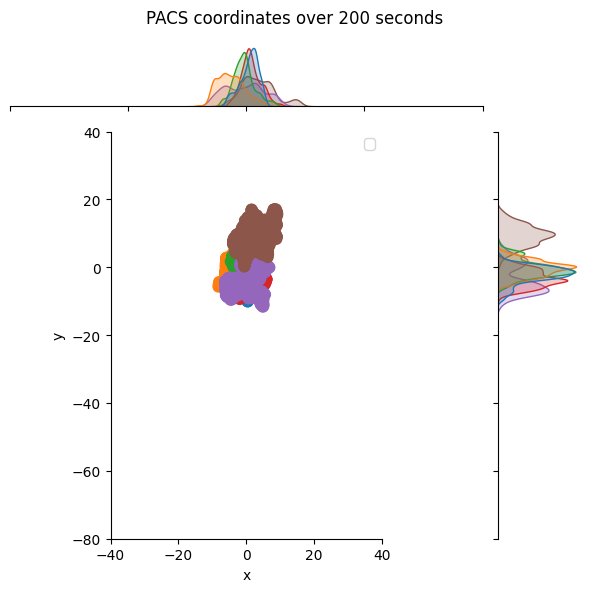

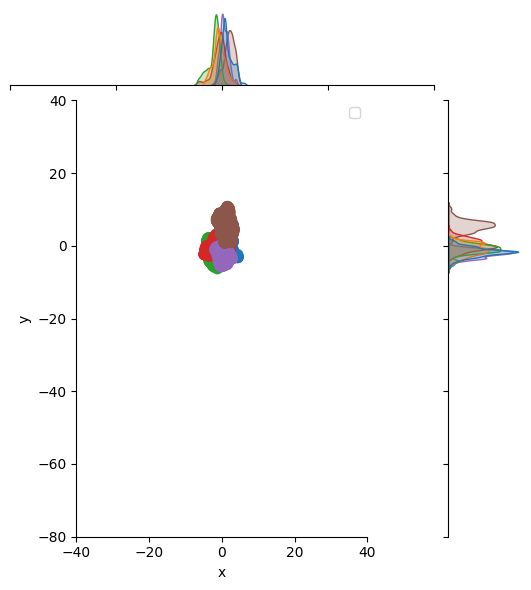

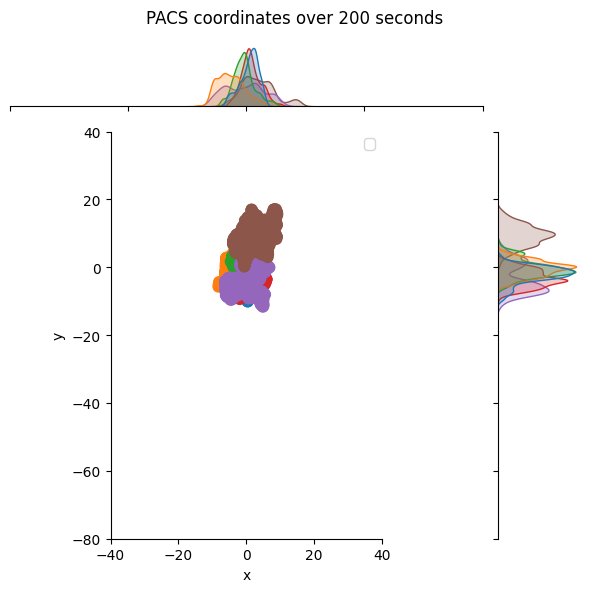

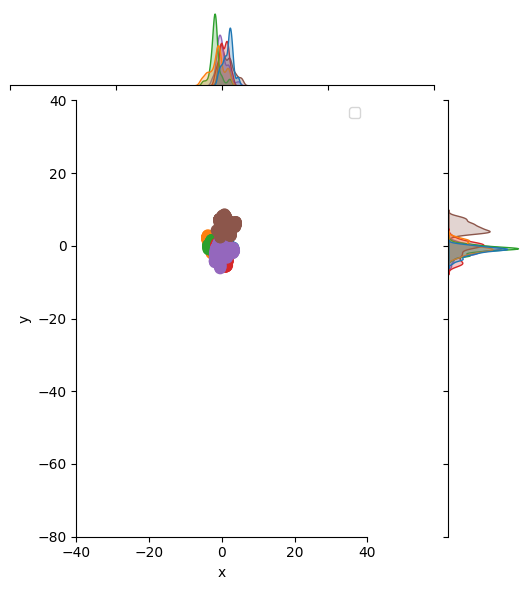

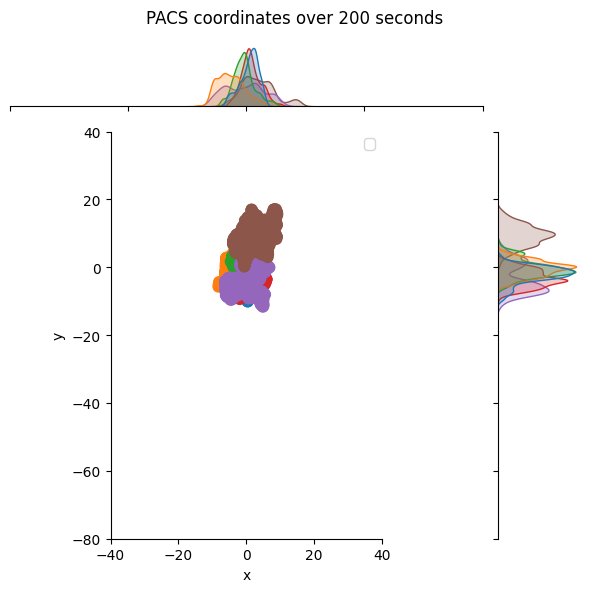

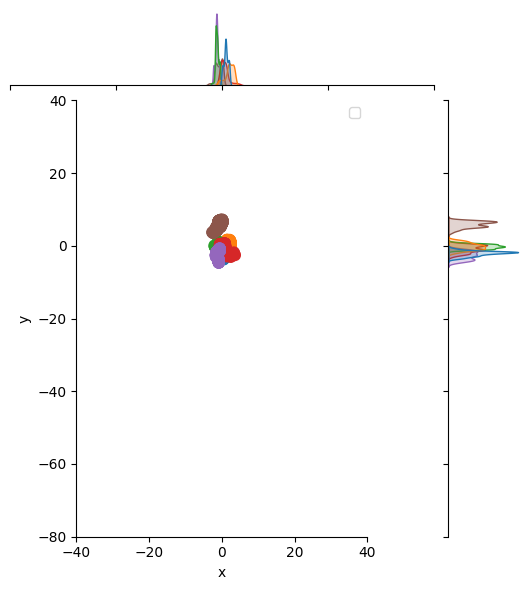

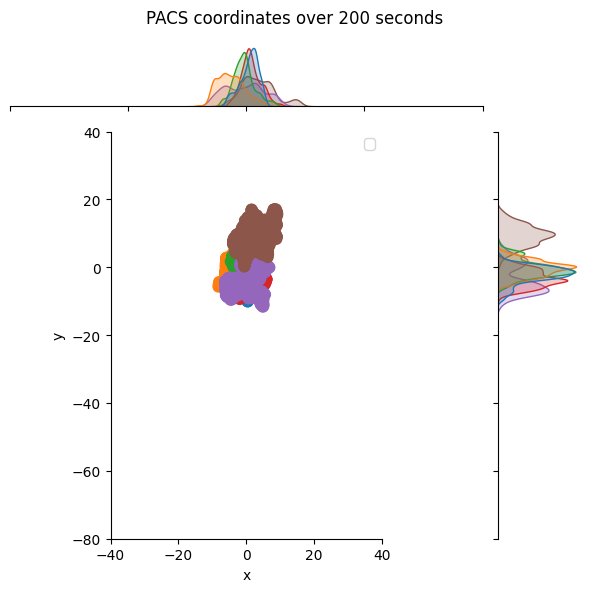

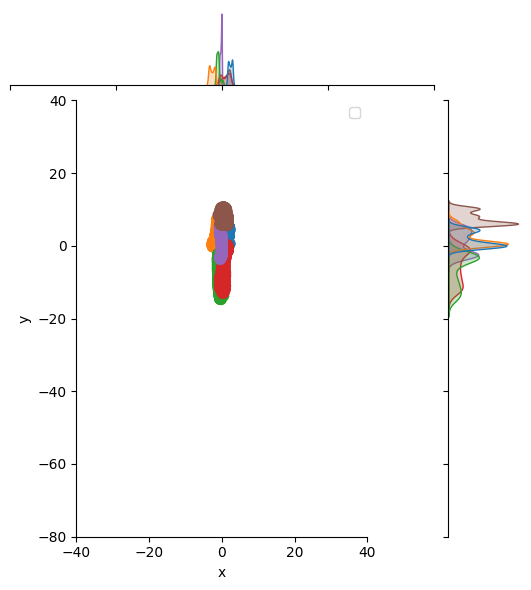

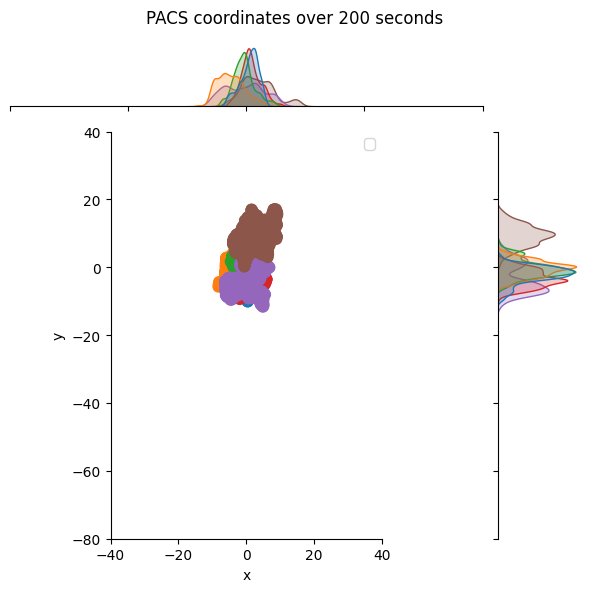

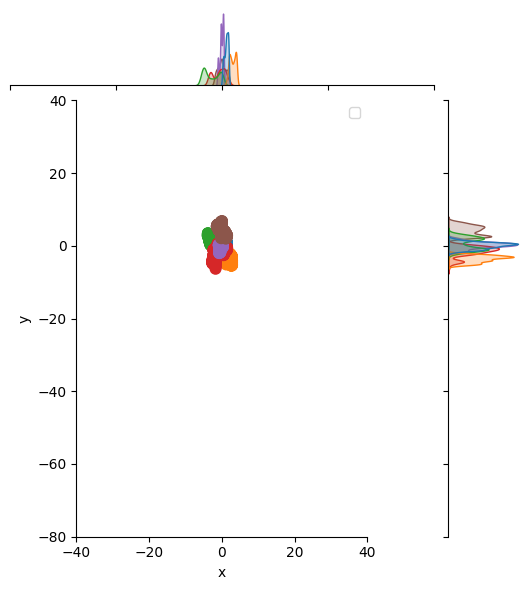

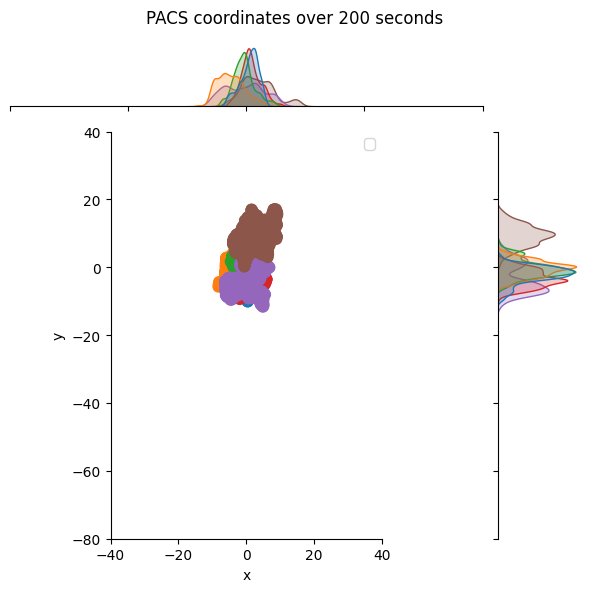

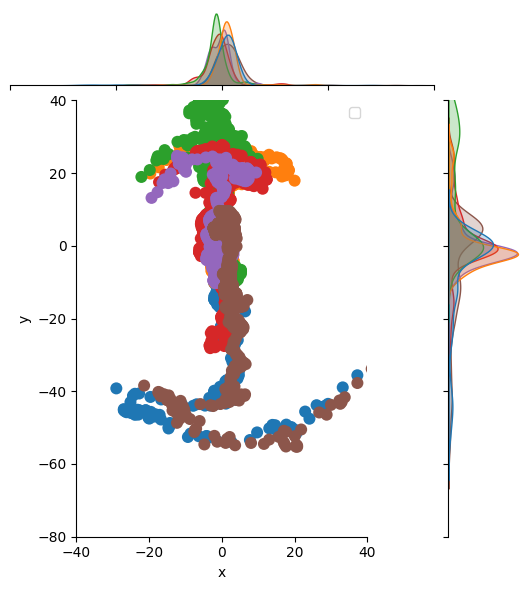

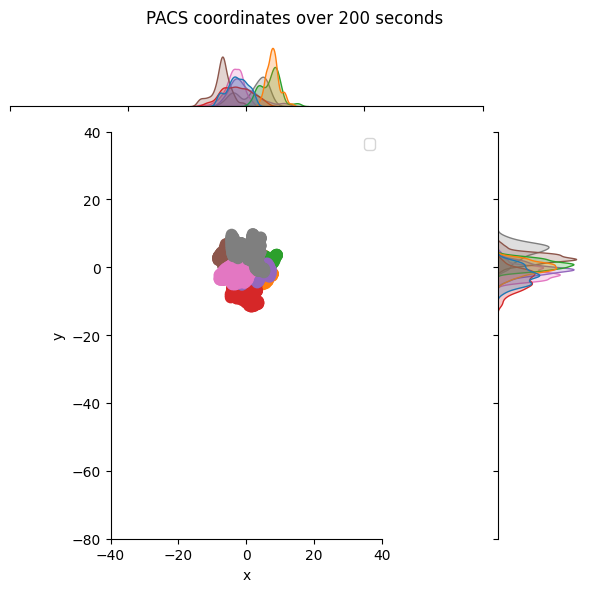

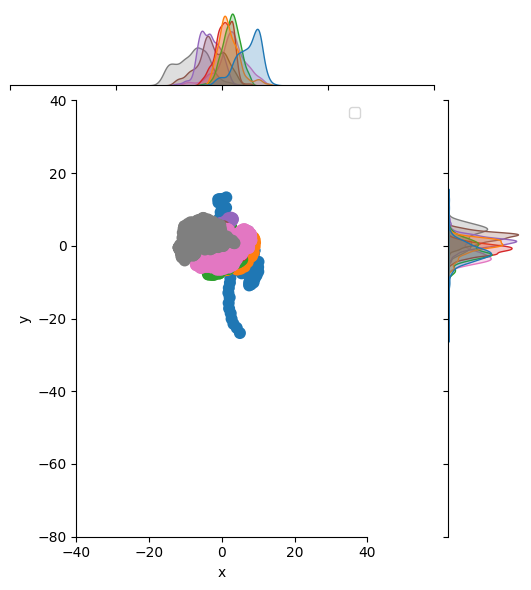

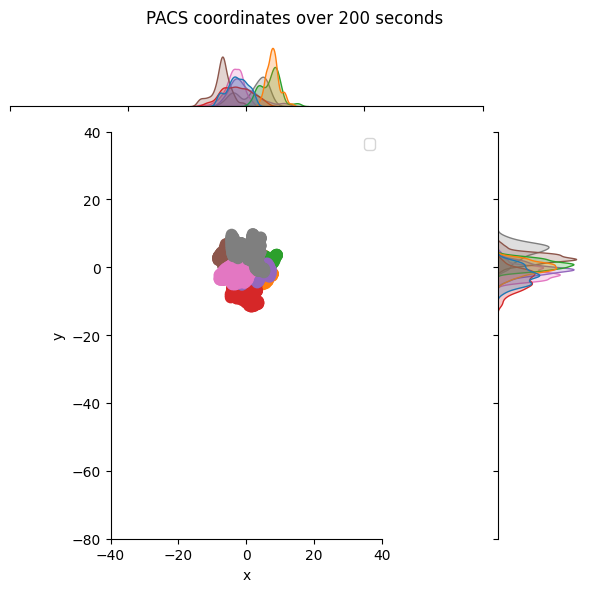

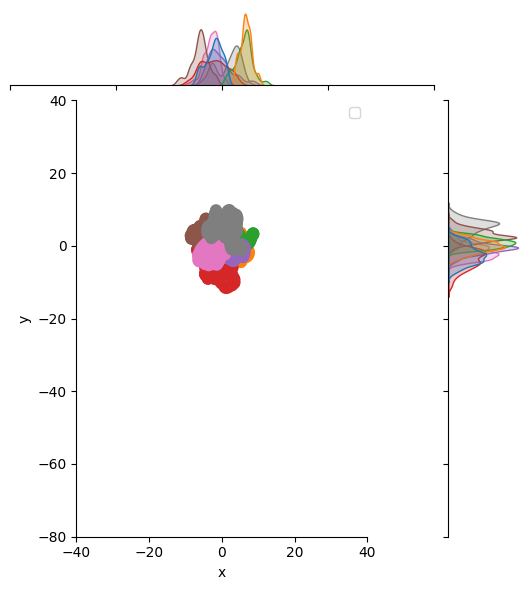

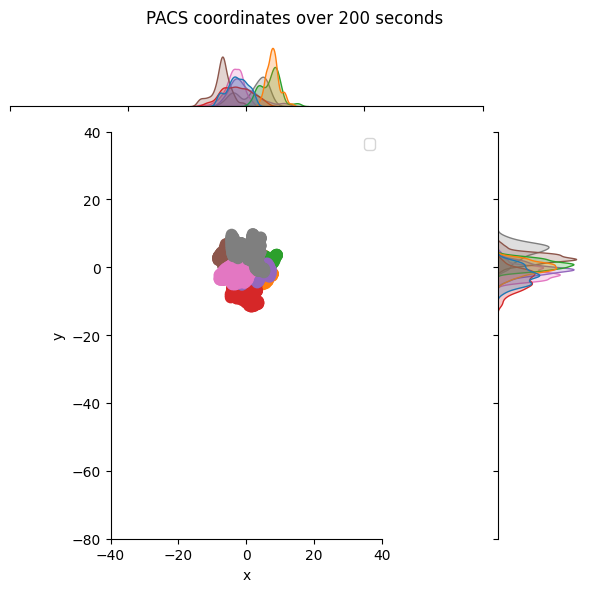

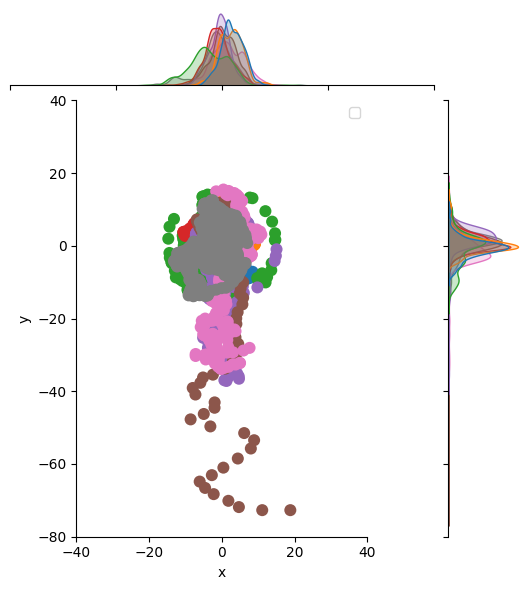

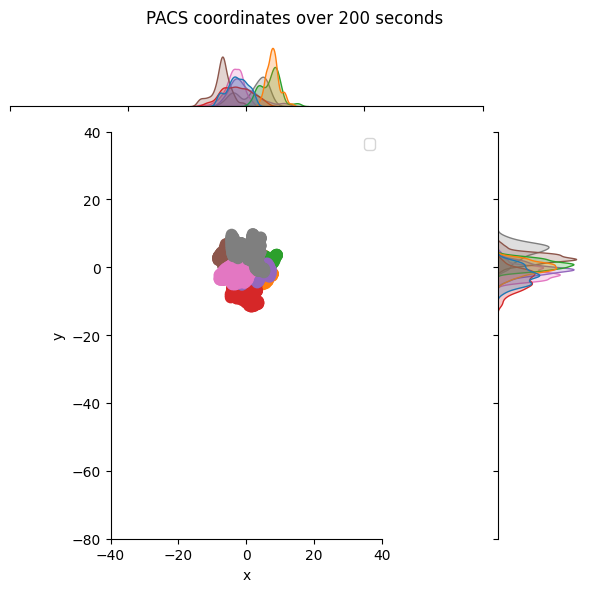

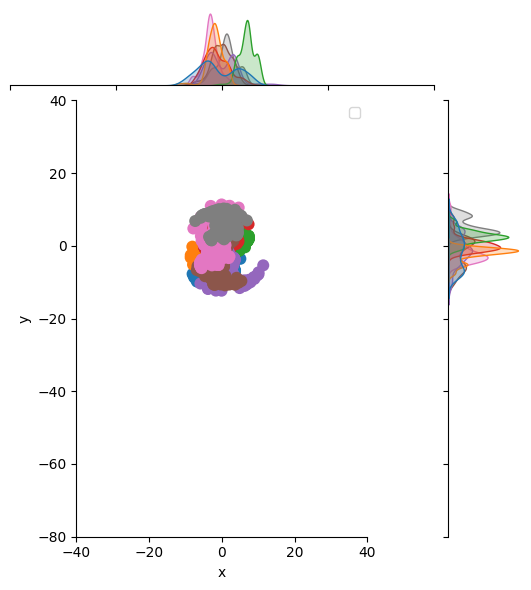

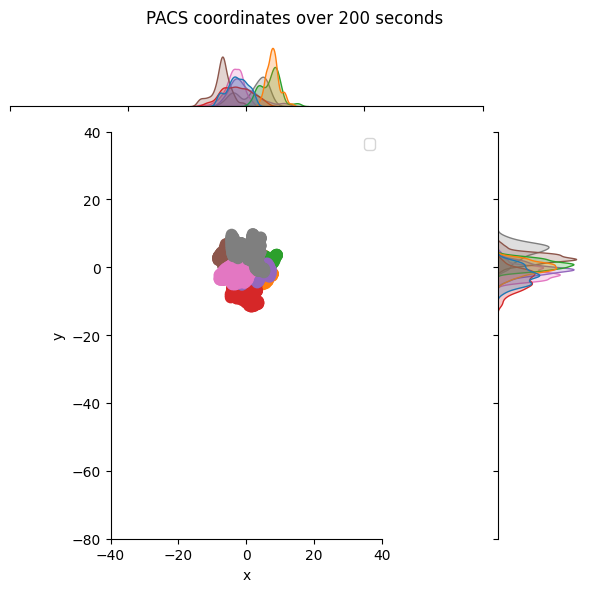

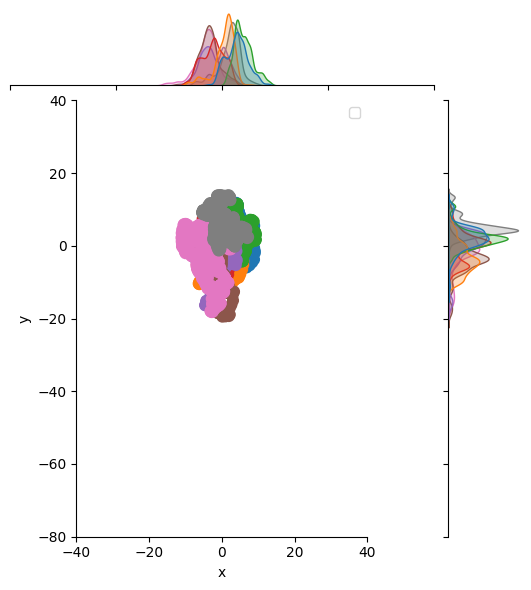

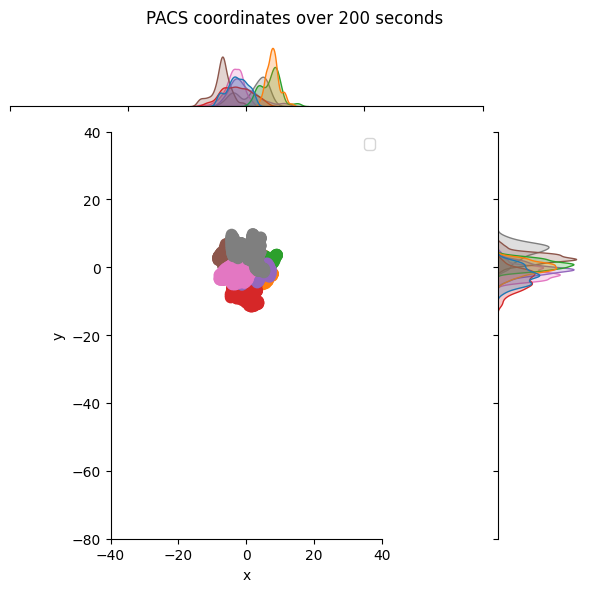

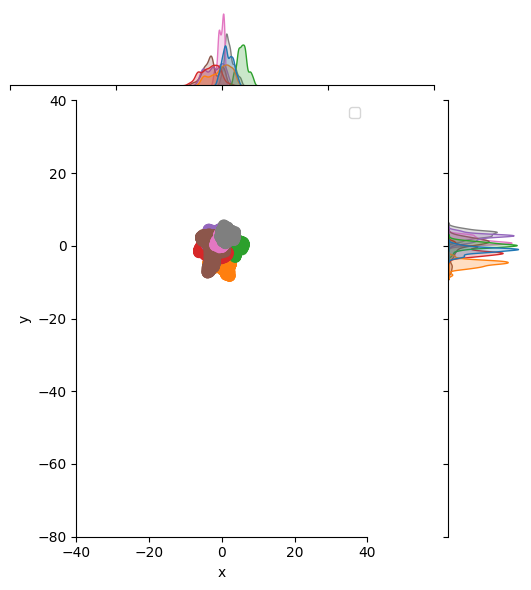

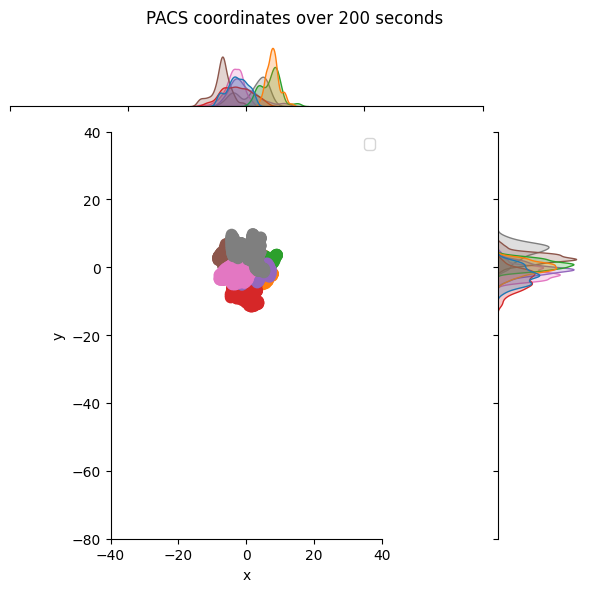

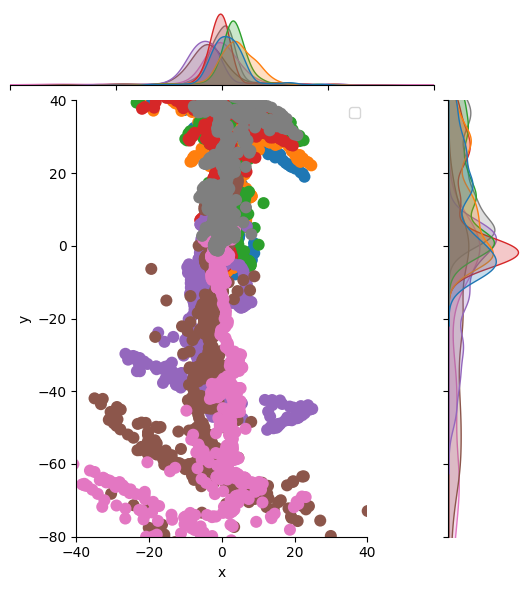

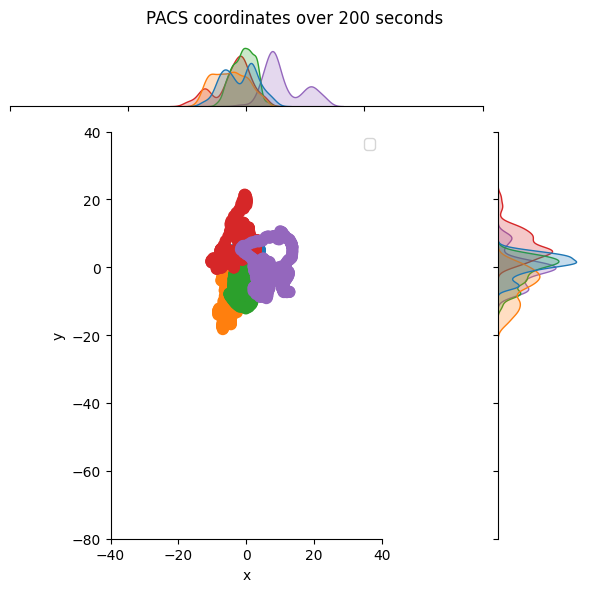

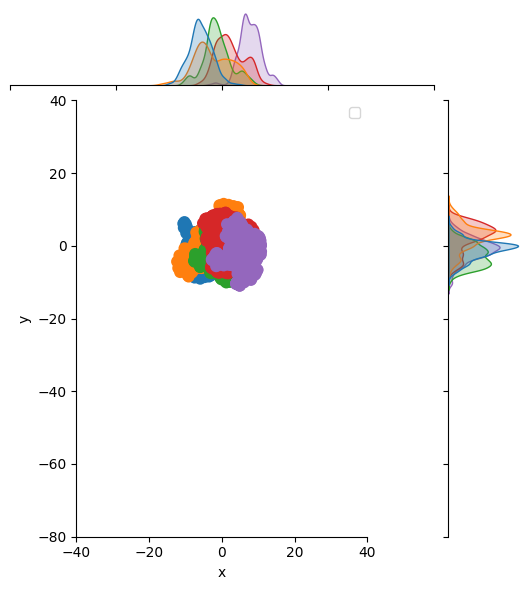

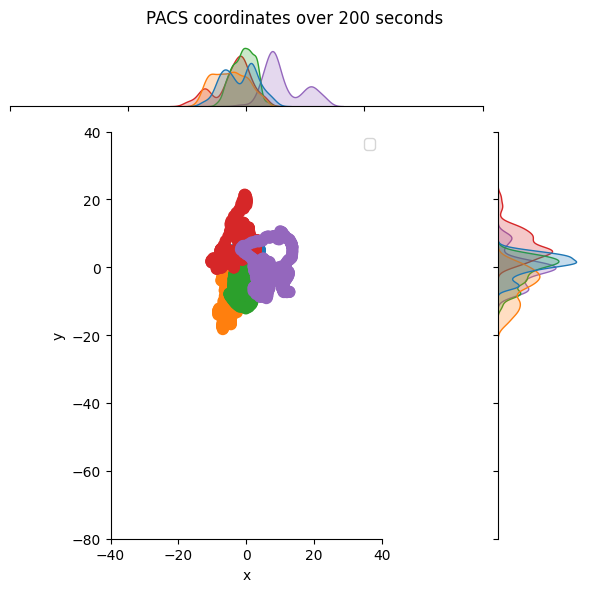

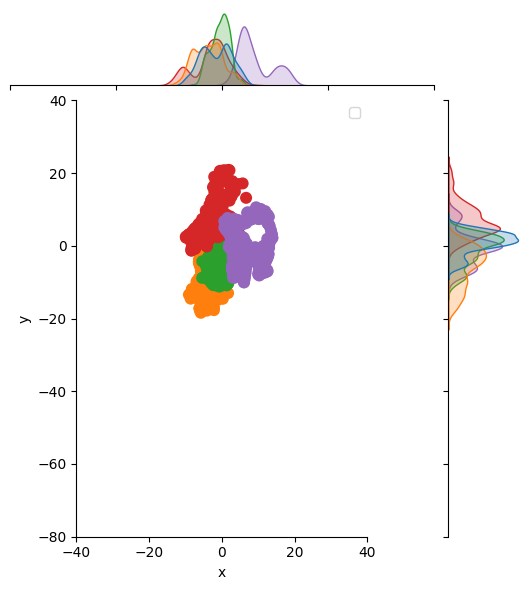

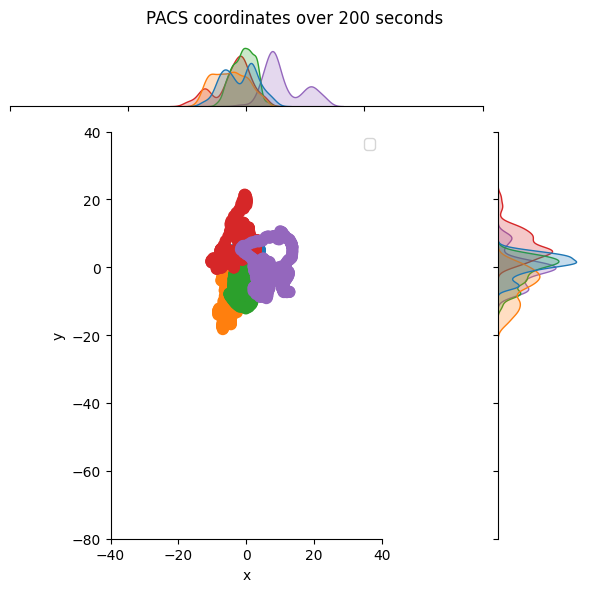

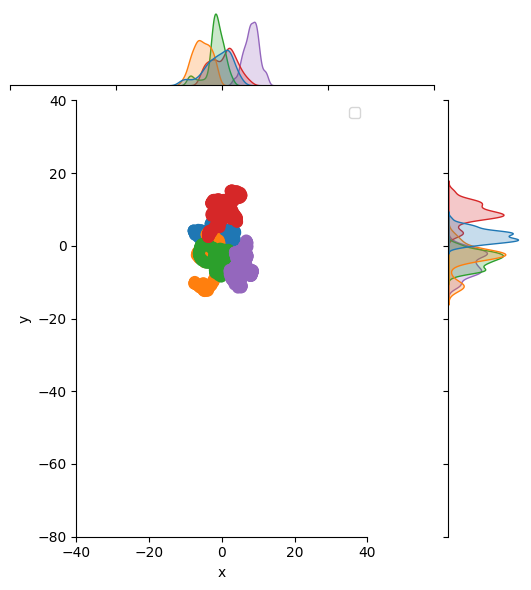

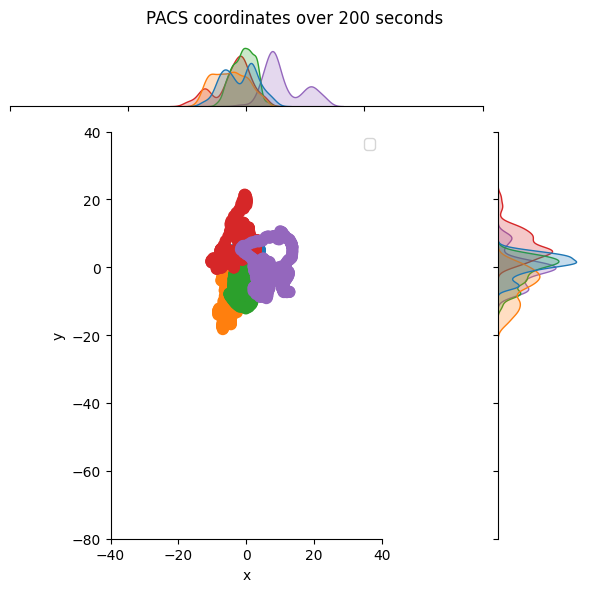

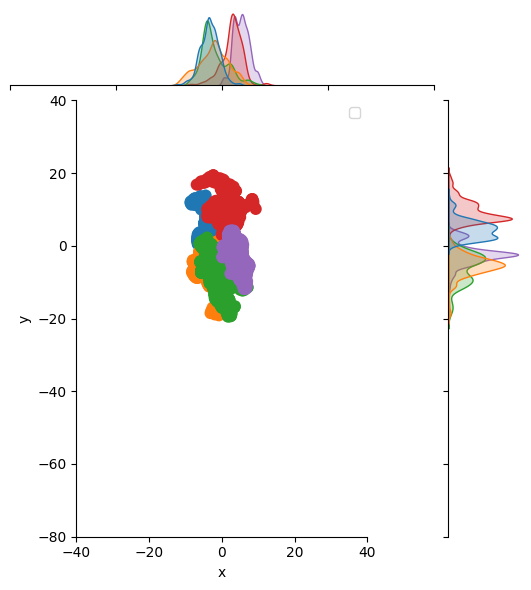

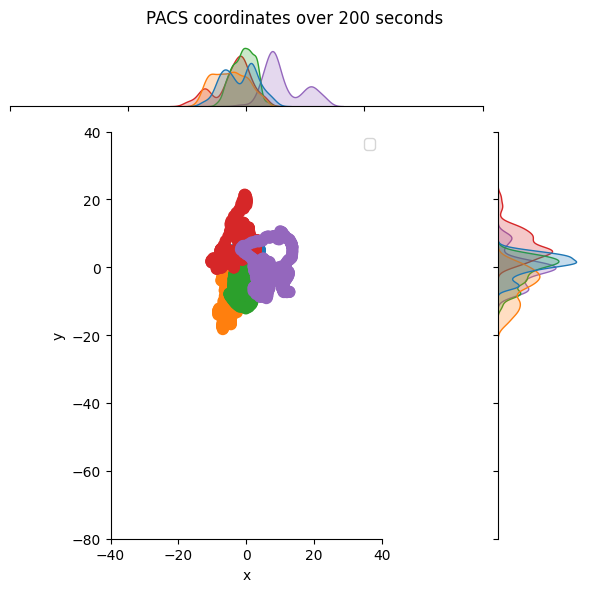

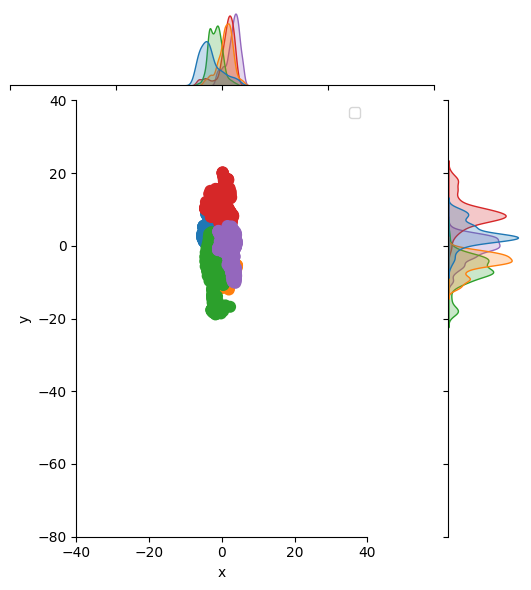

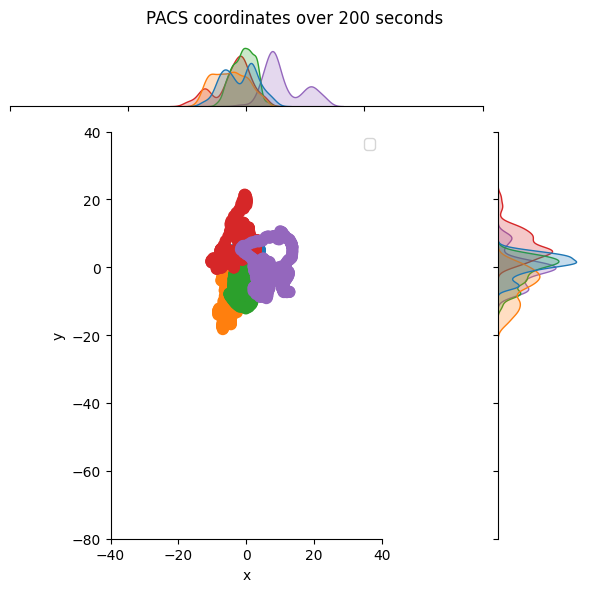

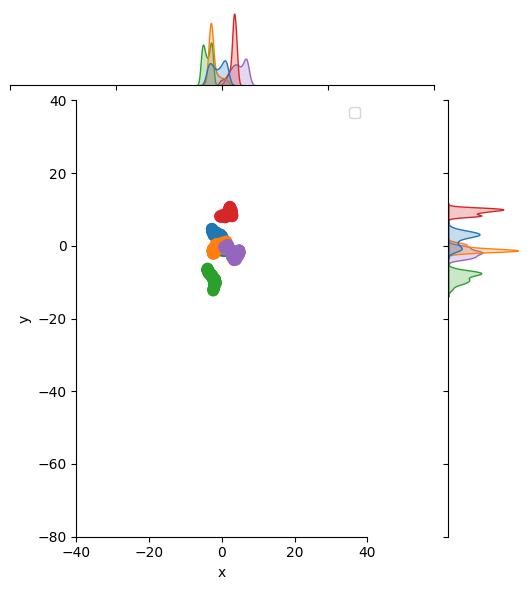

In [181]:
PACS_ent = []
reg_ent = []


for movement_sq in tqdm(movements_bySquad):


    smooth_movements = Preprocessing.spline_smoothing(movement_sq, s=3e1, UTM=True)
    # Get a sample slice of data and apply the Path-Adapted Coordinate System (PACS) transformation
    # Orient ruck periods
    ruck_slices_oriented = PACS.PACS_transform(smooth_movements)
    # Get a names for feature extraction
    names = smooth_movements[test_sq].latitude.columns.tolist()

    random_period = test_per
    random_timepoint = test_time
    sample_time_length = test_len

    # get section
    # random_slice = movement_sq[random_period].iloc[random_timepoint:random_timepoint+sample_time_length].reset_index(drop=True)

    for sm_movements, or_slice in zip(smooth_movements, ruck_slices_oriented):
        random_slice = sm_movements.reset_index(drop=True)
        random_slice_cent = pd.concat([random_slice.UTM_x.mean(axis=1), random_slice.UTM_y.mean(axis=1)], axis=1)

        Xs = pd.concat([random_slice.UTM_x[name] - random_slice_cent[0] for name in random_slice.UTM_x.columns], axis=1, keys = ['UTM_x '+name for name in random_slice.UTM_x.columns])
        Ys = pd.concat([random_slice.UTM_y[name] - random_slice_cent[1] for name in random_slice.UTM_y.columns], axis=1, keys = ['UTM_y '+name for name in random_slice.UTM_y.columns])

        random_slice_norm = pd.concat([Xs, Ys], axis=1)
        # ger forward angle of centroid at each timepoint
        forward_angles = pd.Series([math.degrees(math.atan2(row[1],row[0])) for _ , row in random_slice_cent.diff().iterrows()])
        # angle with respect to positive Y
        forward_angles_y = 90- forward_angles
        forward_angles_y
        # rotate locaitons around origin
        def rotate(point, angle):
            """
            Rotate a point counterclockwise by a given angle around a given origin.

            The angle should be given in radians.
            """
            ox, oy = 0,0
            px, py = point

            qx = ox + math.cos(angle) * (px - ox) - math.sin(angle) * (py - oy)
            qy = oy + math.sin(angle) * (px - ox) + math.cos(angle) * (py - oy)
            return qx, qy
        all_people_roated = []

        names = random_slice.UTM_x.columns

        color_dictionary = dict(zip(names, sns.color_palette(as_cmap=True)[:len(names)]))

        for name in names:
            one_person = pd.concat([random_slice_norm[c] for c in random_slice_norm.columns if name in c], axis=1)

            # rotate
            new_pts = []
            for idx, row in one_person.iterrows():
                new_pts.append(rotate(row, math.radians(forward_angles_y.iloc[idx])))
            one_person_rotated = pd.DataFrame(new_pts, columns=['x', 'y'])

            one_person_rotated['ID'] = name

            all_people_roated.append(one_person_rotated)

        df = pd.concat(all_people_roated)

        hm_df = pd.concat([d.drop(columns='ID').rename(columns = {'x':name + ' longitude', 'y':name+' latitude'}) for d, name in zip(all_people_roated, names)], axis=1)

        time_length = 200

        # get group member names
        names = smooth_movements[0].latitude.columns.tolist()

        # define colors for all plots 
        color_dictionary = dict(zip(names, sns.color_palette(as_cmap=True)[:len(names)]))


        random_period = test_per
        random_timepoint = test_time

        # get section
        random_slice = sm_movements
        random_PACS_slice = ruck_slices_oriented[random_period]

        #  get a sample path
        x_UTM = random_slice[[('UTM_x', n)for n in names]].mean(axis=1)
        y_UTM = random_slice[[('UTM_y', n) for n in names]].mean(axis=1)

        # Get equivalent PACS coordinates
        # make straight line to represent forward movement
        x_PACS = pd.Series(0 * np.arange(time_length))
        y_PACS = pd.Series(np.arange(time_length))

        # initialize indiv datasets list
        indivs_data = []

        # loop through individuals
        for name in names:
            this_person_data = random_PACS_slice[[c for c in random_PACS_slice.columns if name in c]]
            this_person_data.columns = 'x', 'y'
            this_person_data['ID']=name
            indivs_data.append(this_person_data)

        # concat list of indiv datasets to single group dataset
        data_to_plot = pd.concat(indivs_data)

        # initialize jointfig
        jointfig = sns.jointplot(data=data_to_plot.reset_index(), x='x', y='y', hue='ID', dropna=True, palette = color_dictionary, linewidth=0, joint_kws ={'s': 75})
        jointfig.ax_joint.set_aspect('equal')

        # jointfig params
        plt.suptitle('PACS coordinates over ' +str(time_length)+ ' seconds')
        jointfig.ax_joint.legend([])
        jointfig.ax_joint.set_ylim(ylim)
        jointfig.ax_joint.set_xlim(xlim)
        plt.tight_layout()

        # initialize random timepoint for UTM and PACS figs (should be middle of jointplots time-window)
        random_timepoint = random_timepoint + time_length//2
        sample_time_length = 40

        # get section
        random_slice = smooth_movements[random_period]
        random_PACS_slice = ruck_slices_oriented[random_period]

        #  get a sample path
        x_UTM = random_slice[[('UTM_x', n)for n in names]].mean(axis=1)
        y_UTM = random_slice[[('UTM_y', n) for n in names]].mean(axis=1)

        # Get equivalent PACS coordinates
        # make straight line to represent forward movement
        x_PACS = pd.Series(0 * np.arange(sample_time_length))
        y_PACS = pd.Series(np.arange(sample_time_length))

        # choose units (UTM or coords)
        pts = pd.concat([x_UTM, y_UTM], axis=1).to_numpy()

        # get distance values
        distance = np.cumsum( np.sqrt(np.sum( np.diff(pts, axis=0)**2, axis=1 )) )
        distance = np.insert(distance, 0, 0)#/distance[-1]

        # make a spline for each axis
        # splines = [UnivariateSpline(distance, coords, k=3, s=50) for coords in pts.T]
        jointfig = sns.jointplot(data=df.reset_index(), x='x', y='y', hue='ID', dropna=True, palette = color_dictionary, linewidth=0, joint_kws ={'s': 75}, xlim=xlim, ylim=ylim)
        jointfig.ax_joint.set_aspect('equal')
        jointfig.ax_joint.legend([])
        # entropy of these locations

        range = xlim, ylim

        for name in names:

            # name = 'Member 5'
            this_person_PACS = random_PACS_slice[[c for c in random_PACS_slice.columns if name in c]]
            this_person_reg = hm_df[[c for c in hm_df.columns if name in c]]
            # fig, ax = plt.subplots(2, figsize=(5,10))
            PACShist = np.histogram2d(this_person_PACS[name +' longitude'], this_person_PACS[name +' latitude'], density=True, bins=100, range=range)[0]
            # sns.heatmap(PACShist, ax=ax[0])
            reghist = np.histogram2d(this_person_reg[name +' longitude'], this_person_reg[name +' latitude'], density=True, bins=100, range=range)[0]
            # sns.heatmap(reghist, ax=ax[1])

            # plt.suptitle('reg '+ str(shannon_entropy(reghist)) +'   PACS: '+ str(shannon_entropy(PACShist)))

            PACS_ent.append(shannon_entropy(PACShist))
            reg_ent.append(shannon_entropy(reghist))

            # ax[0].set_aspect(1)
            # ax[1].set_aspect(1)




    

<Axes: ylabel='Count'>

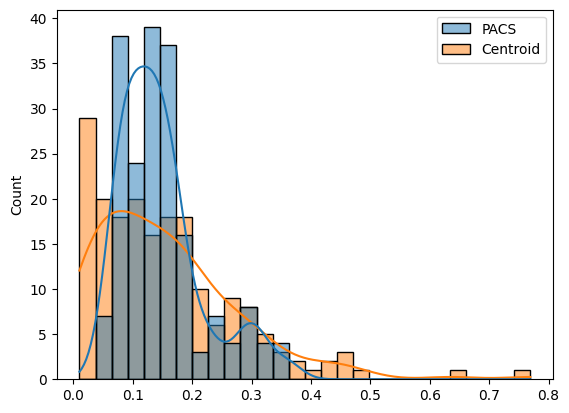

In [182]:
sns.histplot(pd.DataFrame([PACS_ent, reg_ent], index=['PACS', 'Centroid']).T, kde=True)